# Machine Learning for Disaster Response Message Classification

**Project Goal:** Build a multi-label classifier to categorize emergency messages during disasters

**Dataset:** https://www.kaggle.com/datasets/landlord/multilingual-disaster-response-messages

**This notebook includes:**
1. Data Loading & Initial Cleaning
2. Comprehensive Exploratory Data Analysis
3. Advanced Preprocessing & Feature Engineering
4. Data Preparation for Modeling
5. Class Imbalance Handling
6. Top 3 Multi-Label Classification Approaches:
   - XGBoost (Binary Relevance)
   - Classifier Chains (Label Dependencies)
   - Deep Neural Network (Threshold Tuned)
7. Comprehensive Evaluation Metrics
8. Model Comparison & Selection
9.

## 1. Setup & Data Loading

In [5]:
# Install required packages
!pip install nltk scikit-learn pandas numpy matplotlib seaborn wordcloud imbalanced-learn -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import re

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.metrics import (
    classification_report, hamming_loss, accuracy_score,
    f1_score, precision_score, recall_score,
    multilabel_confusion_matrix, make_scorer
)
from sklearn.utils.class_weight import compute_class_weight

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# XGBoost
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

#TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

In [6]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define the source directory in Google Drive
source_dir = '/content/drive/MyDrive/AAI_Capstone/Datasets'
# Define the destination directory
extract_path = '/content/environmental_data/'

# Create the destination directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# List of CSV files to copy
csv_files = [
    'disaster_response_messages_training.csv',
    'disaster_response_messages_validation.csv',
    'disaster_response_messages_test.csv'
]

# Copy each CSV file from the source to the destination
print(f"Copying files from {source_dir} to {extract_path}...")
for file_name in csv_files:
    source_file = os.path.join(source_dir, file_name)
    destination_file = os.path.join(extract_path, file_name)
    if os.path.exists(source_file):
        shutil.copy(source_file, destination_file)
        print(f"Copied {file_name}")
    else:
        print(f"Error: {file_name} not found in {source_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying files from /content/drive/MyDrive/AAI_Capstone/Datasets to /content/environmental_data/...
Copied disaster_response_messages_training.csv
Copied disaster_response_messages_validation.csv
Copied disaster_response_messages_test.csv


## 2. Initial Data Loading & Basic Cleaning

In [7]:
# Paths
TRAIN_PATH = '/content/environmental_data/disaster_response_messages_training.csv'
VAL_PATH = '/content/environmental_data/disaster_response_messages_validation.csv'
TEST_PATH = '/content/environmental_data/disaster_response_messages_test.csv'

# Load datasets with proper dtype handling
print("Loading datasets...")
df_train_raw = pd.read_csv(TRAIN_PATH, low_memory=False)
df_val_raw = pd.read_csv(VAL_PATH, low_memory=False)
df_test_raw = pd.read_csv(TEST_PATH, low_memory=False)

print(f"Training set shape: {df_train_raw.shape}")
print(f"Validation set shape: {df_val_raw.shape}")
print(f"Test set shape: {df_test_raw.shape}")
print(f"\nTotal messages: {len(df_train_raw) + len(df_val_raw) + len(df_test_raw)}")

Loading datasets...
Training set shape: (21046, 42)
Validation set shape: (2573, 42)
Test set shape: (2629, 42)

Total messages: 26248


In [8]:
# Inspect the structure
print(df_train_raw.columns.tolist())

print("\nFirst few rows:")
df_train_raw.head(3)

['id', 'split', 'message', 'original', 'genre', 'related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']

First few rows:


,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Data info
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      21046 non-null  int64 
 1   split                   21046 non-null  object
 2   message                 21046 non-null  object
 3   original                8191 non-null   object
 4   genre                   21046 non-null  object
 5   related                 21046 non-null  int64 
 6   PII                     21046 non-null  int64 
 7   request                 21046 non-null  int64 
 8   offer                   21046 non-null  int64 
 9   aid_related             21046 non-null  int64 
 10  medical_help            21046 non-null  int64 
 11  medical_products        21046 non-null  int64 
 12  search_and_rescue       21046 non-null  int64 
 13  security                21046 non-null  int64 
 14  military                21046 non-null  int64 
 15  ch

In [10]:
# Identify label columns
# Metadata columns: id, split, message, original, genre
metadata_cols = ['id', 'split', 'message', 'original', 'genre']
label_cols = [col for col in df_train_raw.columns if col not in metadata_cols]

print(f"\nIdentified {len(label_cols)} label columns:")
print(label_cols)


Identified 37 label columns:
['related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


## 3. Data Cleaning Pipeline

In [11]:
# function to preprocess data: handle duplicates, fix labels, missing values, basic validation
def clean_dataset(df, dataset_name='Dataset'):

    df = df.copy()
    initial_rows = len(df)

    # 1. Remove duplicates
    df = df.drop_duplicates()
    duplicates_removed = initial_rows - len(df)
    if duplicates_removed > 0:
        print(f"Removed {duplicates_removed} duplicate rows ({duplicates_removed/initial_rows:.2%})")
    else:
        print("No duplicates found")

    # 2. Fix 'related' label (some datasets have value '2' which should be '1')
    if 'related' in df.columns:
        before = df['related'].value_counts().to_dict()
        df['related'] = df['related'].replace(2, 1)
        after = df['related'].value_counts().to_dict()
        if before != after:
            print(f"Fixed 'related' label: replaced {before.get(2, 0)} values of '2' with '1'")

    # 3. Handle missing values
    null_before = df.isnull().sum().sum()

    # Drop rows missing the actual message content
    rows_before_drop = len(df)
    df = df.dropna(subset=['message'])
    message_nulls = rows_before_drop - len(df)
    if message_nulls > 0:
        print(f"Dropped {message_nulls} rows with missing messages")

    # Fill missing 'original' text with placeholder
    if 'original' in df.columns:
        original_nulls = df['original'].isnull().sum()
        df['original'] = df['original'].fillna('N/A')
        if original_nulls > 0:
            print(f"Filled {original_nulls} missing 'original' values with 'N/A'")

    null_after = df.isnull().sum().sum()

    # 4. Validation
    print(f"\nFinal validation:")
    print(f"  - Shape: {df.shape}")
    print(f"  - Remaining nulls: {null_after}")
    print(f"  - Data retained: {len(df)/initial_rows:.2%}")

    return df

# Apply cleaning to all datasets
df_train = clean_dataset(df_train_raw, 'TRAINING SET')
df_val = clean_dataset(df_val_raw, 'VALIDATION SET')
df_test = clean_dataset(df_test_raw, 'TEST SET')

Removed 19 duplicate rows (0.09%)
Fixed 'related' label: replaced 163 values of '2' with '1'
Filled 12850 missing 'original' values with 'N/A'

Final validation:
  - Shape: (21027, 42)
  - Remaining nulls: 0
  - Data retained: 99.91%
Removed 2 duplicate rows (0.08%)
Fixed 'related' label: replaced 16 values of '2' with '1'
Filled 1584 missing 'original' values with 'N/A'

Final validation:
  - Shape: (2571, 42)
  - Remaining nulls: 0
  - Data retained: 99.92%
Removed 11 duplicate rows (0.42%)
Fixed 'related' label: replaced 9 values of '2' with '1'
Filled 1612 missing 'original' values with 'N/A'

Final validation:
  - Shape: (2618, 42)
  - Remaining nulls: 0
  - Data retained: 99.58%


## 4. Exploratory Data Analysis (EDA)

### 4.1 Basic Statistics

        Count  Percentage
genre                    
news    10446   49.678984
direct   8652   41.147097
social   1929    9.173919


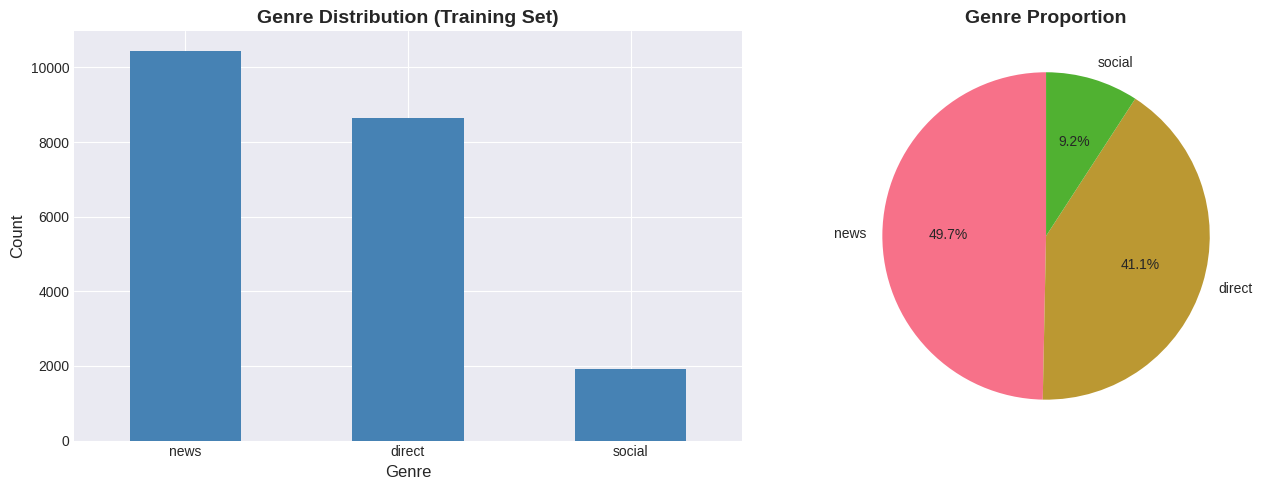

In [12]:
# Genre distribution
genre_dist = df_train['genre'].value_counts()
genre_pct = df_train['genre'].value_counts(normalize=True)

genre_df = pd.DataFrame({
    'Count': genre_dist,
    'Percentage': genre_pct * 100
})
print(genre_df)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
genre_dist.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Genre Distribution (Training Set)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Genre', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=0)

# Pie chart
genre_dist.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Genre Proportion', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

### 4.2 Label Distribution Analysis

In [13]:
# Calculate label statistics
label_stats = pd.DataFrame({
    'positive_count': df_train[label_cols].sum(),
    'negative_count': len(df_train) - df_train[label_cols].sum(),
    'positive_pct': (df_train[label_cols].sum() / len(df_train) * 100)
})

label_stats['imbalance_ratio'] = label_stats['negative_count'] / label_stats['positive_count']
label_stats = label_stats.sort_values('positive_count', ascending=False)

print("\nTop 10 Most Common Labels:")
print(label_stats.head(10))

print("\nTop 10 Rarest Labels:")
print(label_stats.tail(10))


Top 10 Most Common Labels:
                 positive_count  negative_count  positive_pct  imbalance_ratio
related                   15946            5081     75.835830         0.318638
aid_related                8677           12350     41.265991         1.423303
weather_related            5862           15165     27.878442         2.587001
direct_report              4004           17023     19.042184         4.251499
request                    3556           17471     16.911590         4.913105
other_aid                  2875           18152     13.672897         6.313739
food                       2325           18702     11.057212         8.043871
earthquake                 1979           19048      9.411709         9.625063
storm                      1971           19056      9.373662         9.668189
shelter                    1875           19152      8.917107        10.214400

Top 10 Rarest Labels:
                positive_count  negative_count  positive_pct  imbalance_ratio
cl

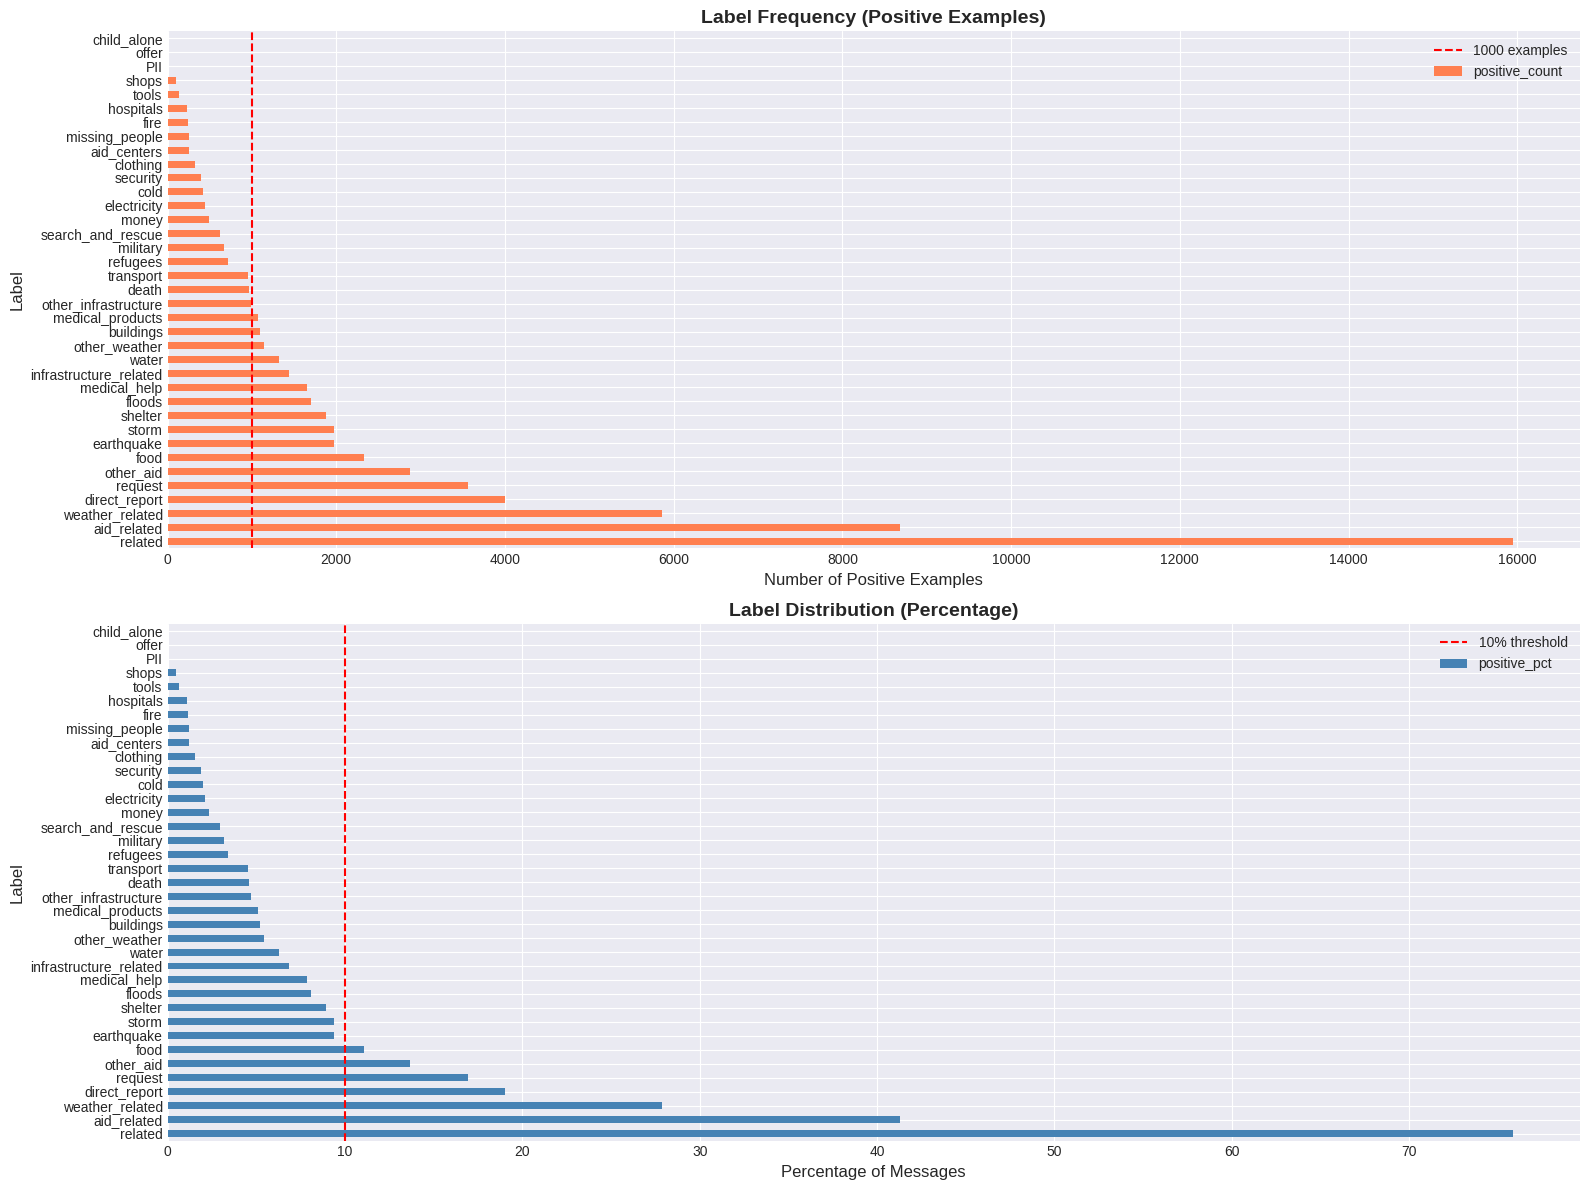


Severely imbalanced labels (<5%): 20
                      positive_count  positive_pct  imbalance_ratio
other_infrastructure             988      4.698721        20.282389
death                            963      4.579826        20.834891
transport                        948      4.508489        21.180380
refugees                         718      3.414657        28.285515
military                         664      3.157845        30.667169
search_and_rescue                620      2.948590        32.914516
money                            487      2.316070        42.176591
electricity                      449      2.135350        45.830735
cold                             425      2.021211        48.475294
security                         402      1.911828        51.305970
clothing                         323      1.536120        64.099071
aid_centers                      258      1.226994        80.500000
missing_people                   252      1.198459        82.440476
fire      

In [14]:
# Visualize label distribution
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Positive counts
label_stats['positive_count'].plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_title('Label Frequency (Positive Examples)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Positive Examples', fontsize=12)
axes[0].set_ylabel('Label', fontsize=12)
axes[0].axvline(x=1000, color='red', linestyle='--', label='1000 examples')
axes[0].legend()

# Plot 2: Percentage distribution
label_stats['positive_pct'].plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Percentage of Messages', fontsize=12)
axes[1].set_ylabel('Label', fontsize=12)
axes[1].axvline(x=10, color='red', linestyle='--', label='10% threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Identify severely imbalanced labels
severe_imbalance = label_stats[label_stats['positive_pct'] < 5]
moderate_imbalance = label_stats[(label_stats['positive_pct'] >= 5) & (label_stats['positive_pct'] < 10)]

print(f"\nSeverely imbalanced labels (<5%): {len(severe_imbalance)}")
print(severe_imbalance[['positive_count', 'positive_pct', 'imbalance_ratio']])

print(f"\nModerately imbalanced labels (5-10%): {len(moderate_imbalance)}")
print(moderate_imbalance[['positive_count', 'positive_pct', 'imbalance_ratio']])

### 4.3 Multi-Label Analysis

In [15]:
# Calculate number of labels per message
df_train['label_count'] = df_train[label_cols].sum(axis=1)

# Statistics
print(f"\nLabel Count Statistics:")
print(df_train['label_count'].describe())

print(f"\nMessages with no labels: {(df_train['label_count'] == 0).sum()} ({(df_train['label_count'] == 0).sum()/len(df_train):.2%})")
print(f"Messages with 1 label: {(df_train['label_count'] == 1).sum()} ({(df_train['label_count'] == 1).sum()/len(df_train):.2%})")
print(f"Messages with 2+ labels: {(df_train['label_count'] >= 2).sum()} ({(df_train['label_count'] >= 2).sum()/len(df_train):.2%})")
print(f"Max labels on single message: {df_train['label_count'].max()}")


Label Count Statistics:
count    21027.000000
mean         3.171256
std          3.024585
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         27.000000
Name: label_count, dtype: float64

Messages with no labels: 5081 (24.16%)
Messages with 1 label: 4203 (19.99%)
Messages with 2+ labels: 11743 (55.85%)
Max labels on single message: 27


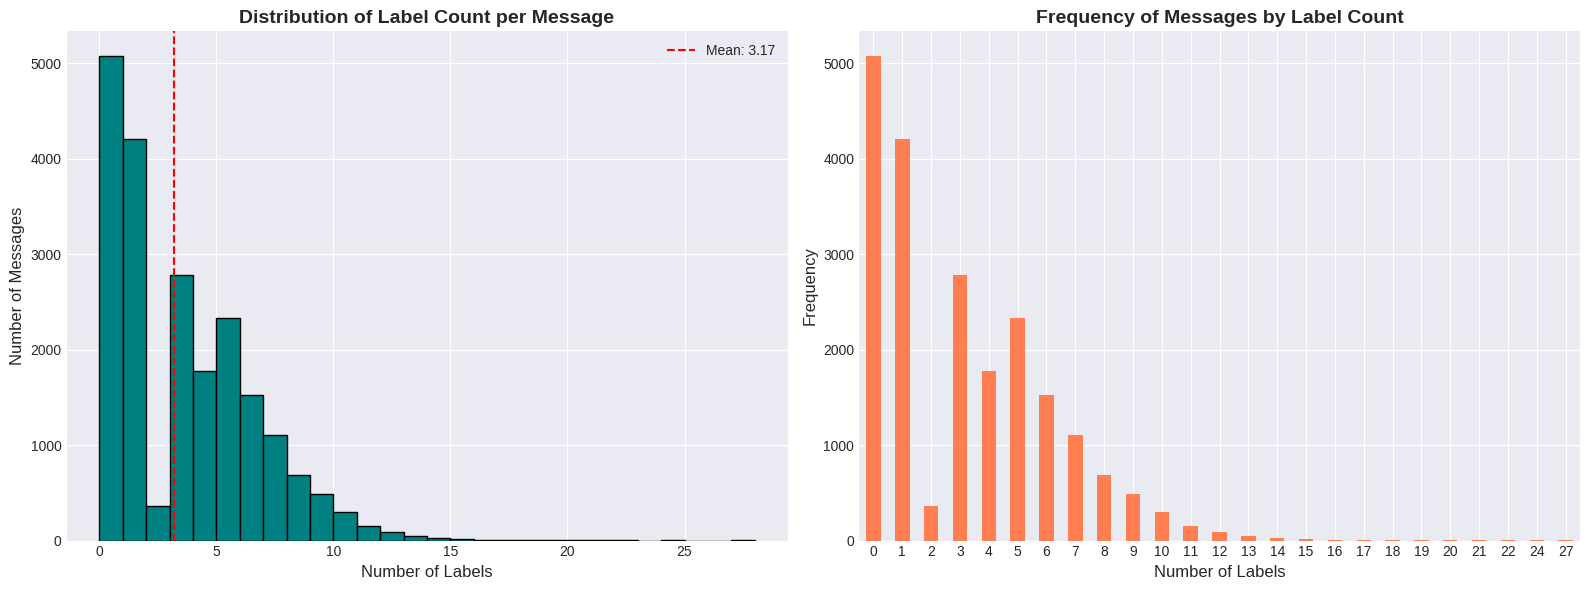

In [16]:
# Visualize label count distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
df_train['label_count'].hist(bins=range(0, df_train['label_count'].max()+2), ax=ax1, color='teal', edgecolor='black')
ax1.set_title('Distribution of Label Count per Message', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Labels', fontsize=12)
ax1.set_ylabel('Number of Messages', fontsize=12)
ax1.axvline(x=df_train['label_count'].mean(), color='red', linestyle='--', label=f'Mean: {df_train["label_count"].mean():.2f}')
ax1.legend()

# Value counts
label_count_dist = df_train['label_count'].value_counts().sort_index()
label_count_dist.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Frequency of Messages by Label Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Labels', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 4.4 Label Co-occurrence Analysis

In [17]:
# Calculate correlation between labels
label_corr = df_train[label_cols].corr()

# Find most common label combinations (for messages with 2+ labels)
multi_label_msgs = df_train[df_train['label_count'] >= 2].copy()
multi_label_msgs['label_combination'] = multi_label_msgs[label_cols].apply(
    lambda x: ', '.join(sorted([col for col, val in x.items() if val == 1])),
    axis=1
)

print(f"\nTop 20 Most Common Label Combinations:")
top_combos = multi_label_msgs['label_combination'].value_counts().head(20)
for i, (combo, count) in enumerate(top_combos.items(), 1):
    print(f"{i:2d}. [{count:4d}] {combo}")


Top 20 Most Common Label Combinations:
 1. [ 561] earthquake, related, weather_related
 2. [ 341] related, storm, weather_related
 3. [ 326] aid_related, direct_report, other_aid, related, request
 4. [ 285] aid_related, direct_report, food, related, request
 5. [ 218] aid_related, military, related
 6. [ 215] aid_related, other_aid, related
 7. [ 211] aid_related, medical_help, related
 8. [ 201] aid_related, food, related
 9. [ 199] direct_report, related, request
10. [ 156] direct_report, related, storm, weather_related
11. [ 154] direct_report, related
12. [ 141] aid_related, direct_report, related, request, shelter
13. [ 141] floods, related, weather_related
14. [ 123] aid_related, direct_report, food, related, request, water
15. [ 120] other_weather, related, weather_related
16. [ 117] aid_related, earthquake, other_aid, related, weather_related
17. [  99] direct_report, earthquake, related, weather_related
18. [  99] related, request
19. [  87] floods, related, storm, weather_r

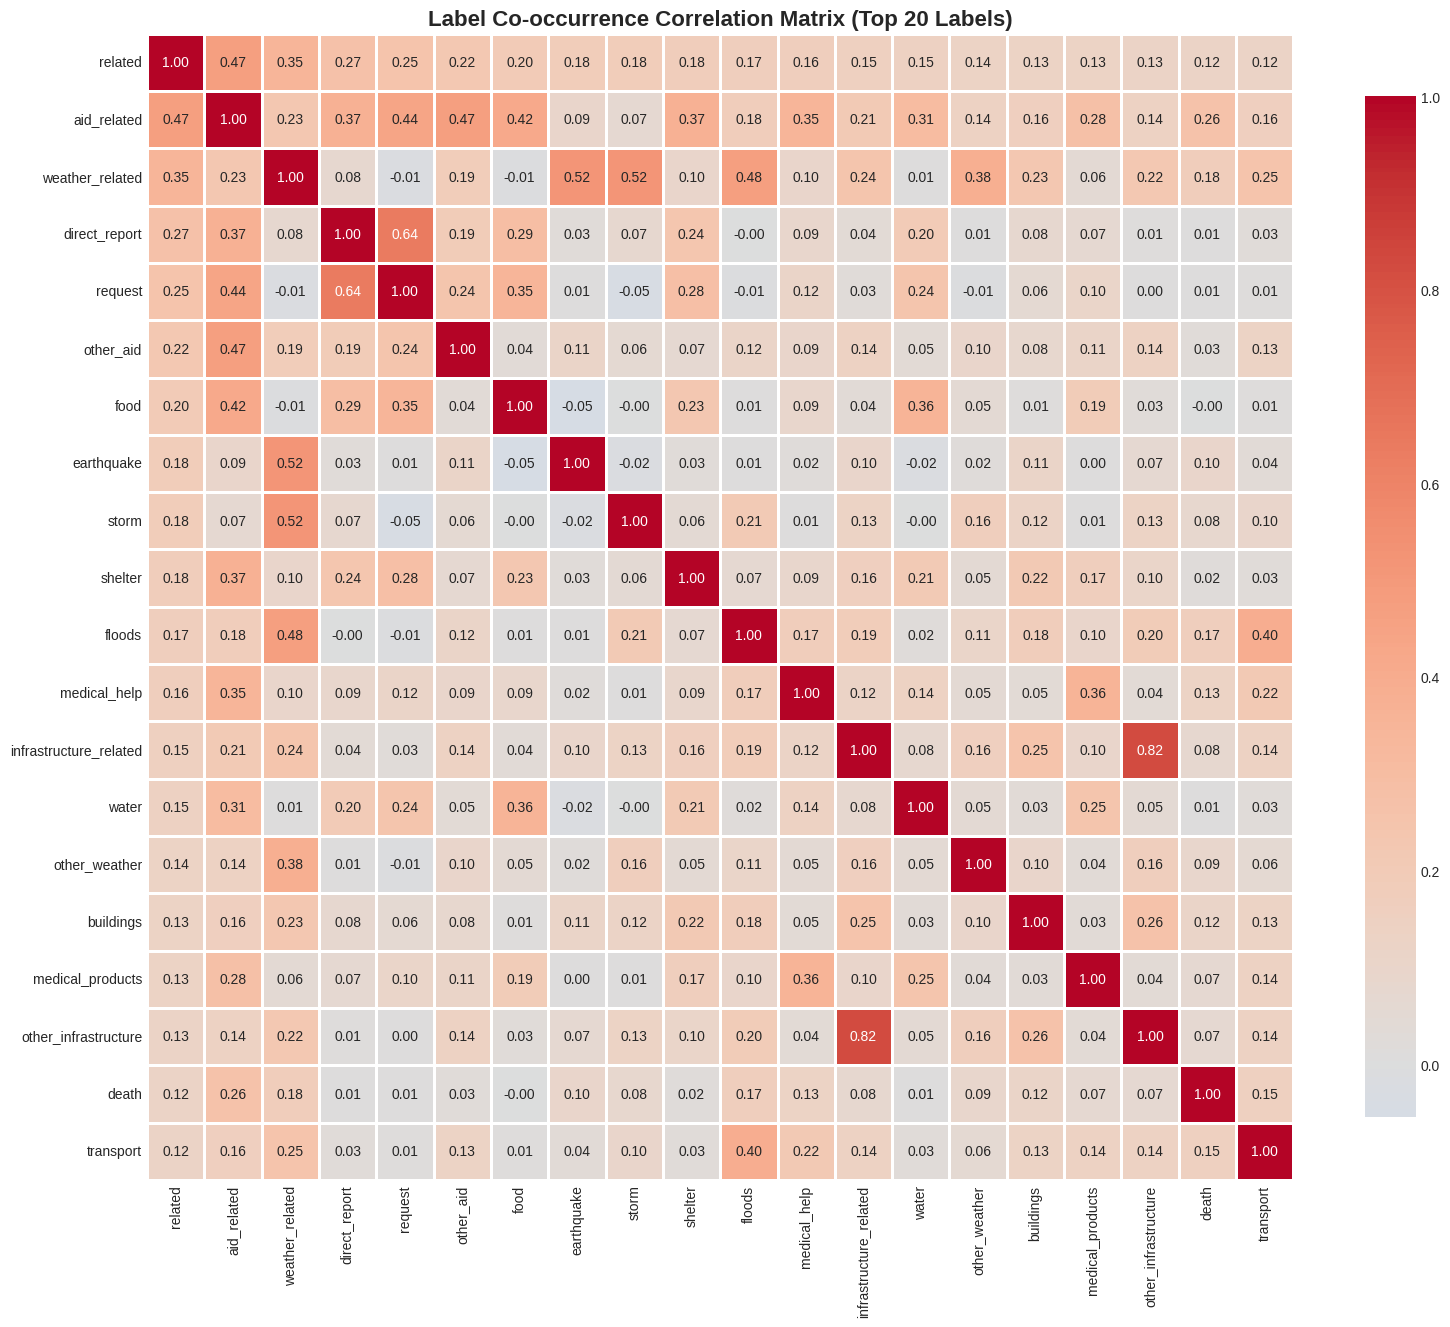


Strongest Positive Correlations (excluding diagonal):
                     label1                label2  correlation
537  infrastructure_related  other_infrastructure     0.819534
104                 request         direct_report     0.637483
641         weather_related            earthquake     0.518438
639         weather_related                 storm     0.517280
638         weather_related                floods     0.476414
152             aid_related             other_aid     0.474794
3                   related           aid_related     0.473151
72                  request           aid_related     0.443914
145             aid_related                  food     0.420645
536  infrastructure_related           aid_centers     0.411366
554               transport                floods     0.398580
534  infrastructure_related             hospitals     0.386432
643         weather_related         other_weather     0.384736
146             aid_related               shelter     0.373286


In [18]:
# Visualize correlation heatmap (for top labels only to keep it readable)
top_labels = label_stats.head(20).index.tolist()
label_corr_top = df_train[top_labels].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(label_corr_top, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Label Co-occurrence Correlation Matrix (Top 20 Labels)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find strongest correlations
print("\nStrongest Positive Correlations (excluding diagonal):")
corr_pairs = []
for i in range(len(label_corr.columns)):
    for j in range(i+1, len(label_corr.columns)):
        corr_pairs.append({
            'label1': label_corr.columns[i],
            'label2': label_corr.columns[j],
            'correlation': label_corr.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', ascending=False)
print(corr_df.head(15))

### 4.5 Message Characteristics Analysis

In [19]:
# Calculate message features
df_train['message_length'] = df_train['message'].str.len()
df_train['word_count'] = df_train['message'].str.split().str.len()
df_train['avg_word_length'] = df_train['message_length'] / df_train['word_count']
df_train['exclamation_count'] = df_train['message'].str.count('!')
df_train['question_count'] = df_train['message'].str.count('\?')
df_train['has_urls'] = df_train['message'].str.contains(r'http[s]?://', na=False)
df_train['has_numbers'] = df_train['message'].str.contains(r'\d+', na=False)

# Basic statistics
print("\nMessage Length Statistics (characters):")
print(df_train['message_length'].describe())

print("\nWord Count Statistics:")
print(df_train['word_count'].describe())

print("\nAdditional Features:")
print(f"Messages with URLs: {df_train['has_urls'].sum()} ({df_train['has_urls'].sum()/len(df_train):.2%})")
print(f"Messages with numbers: {df_train['has_numbers'].sum()} ({df_train['has_numbers'].sum()/len(df_train):.2%})")
print(f"Messages with exclamations: {(df_train['exclamation_count'] > 0).sum()}")
print(f"Messages with questions: {(df_train['question_count'] > 0).sum()}")
print(f"Very short messages (<5 words): {(df_train['word_count'] < 5).sum()}")


Message Length Statistics (characters):
count    21027.000000
mean       143.891948
std        200.749772
min          4.000000
25%         74.000000
50%        124.000000
75%        179.000000
max      10818.000000
Name: message_length, dtype: float64

Word Count Statistics:
count    21027.000000
mean        23.722262
std         31.158232
min          0.000000
25%         13.000000
50%         21.000000
75%         29.000000
max       1686.000000
Name: word_count, dtype: float64

Additional Features:
Messages with URLs: 553 (2.63%)
Messages with numbers: 6125 (29.13%)
Messages with exclamations: 741
Messages with questions: 1763
Very short messages (<5 words): 81


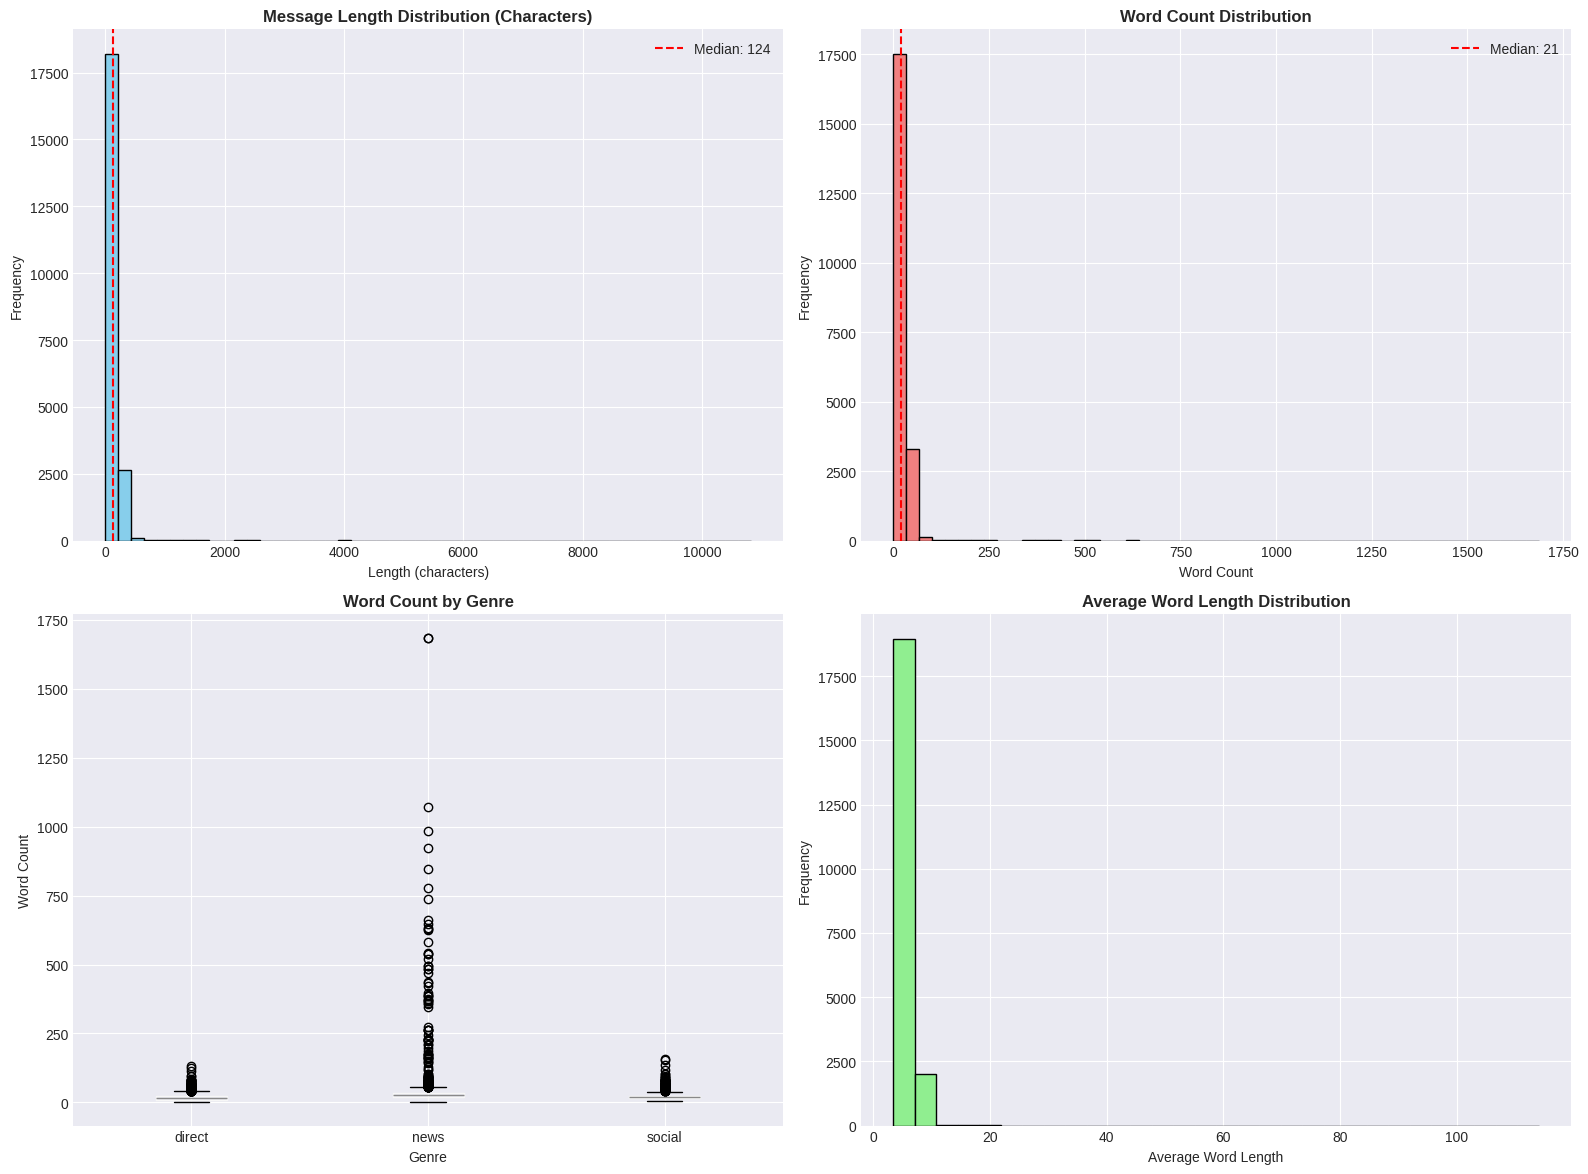

In [20]:
# Visualize message characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Message length distribution
axes[0, 0].hist(df_train['message_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Message Length Distribution (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(x=df_train['message_length'].median(), color='red', linestyle='--',
                   label=f'Median: {df_train["message_length"].median():.0f}')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(df_train['word_count'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(x=df_train['word_count'].median(), color='red', linestyle='--',
                   label=f'Median: {df_train["word_count"].median():.0f}')
axes[0, 1].legend()

# Word count by genre
df_train.boxplot(column='word_count', by='genre', ax=axes[1, 0])
axes[1, 0].set_title('Word Count by Genre', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Genre')
axes[1, 0].set_ylabel('Word Count')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# Average word length
# Handle infinite values resulting from division by zero (messages with 0 words)
avg_word_length_cleaned = df_train['avg_word_length'].replace([np.inf, -np.inf], np.nan).dropna()
axes[1, 1].hist(avg_word_length_cleaned, bins=30, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Average Word Length Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Word Length')
axes[1, 1].set_ylabel('Frequency')

plt.suptitle('')  # Remove auto-generated title from boxplot
plt.tight_layout()
plt.show()

### 4.6 Genre-Specific Analysis

In [21]:
# Calculate label distribution by genre
genre_label_dist = df_train.groupby('genre')[label_cols].mean() * 100  # Convert to percentage

print("\nLabel prevalence (%) by genre:")
print(genre_label_dist.T.sort_values('direct', ascending=False).head(15))


Label prevalence (%) by genre:
genre                      direct       news     social
related                 67.082755  81.064522  86.780715
aid_related             39.921405  44.744400  28.460342
request                 33.899676   4.700364   6.842924
direct_report           32.720758   6.557534  25.298082
food                    16.562644   7.715872   4.458269
other_aid               14.909847  12.636416  13.737688
weather_related         14.227924  32.854681  62.156558
shelter                 10.737402   8.682749   2.021773
water                    7.720758   5.858702   2.073613
earthquake               7.489598   7.045759  30.844997
medical_help             5.247342  10.894122   3.162260
medical_products         4.299584   6.279916   2.229134
buildings                3.652335   6.586253   4.613790
infrastructure_related   3.294036   9.869807   6.324520
storm                    2.958853  11.085583  28.875065


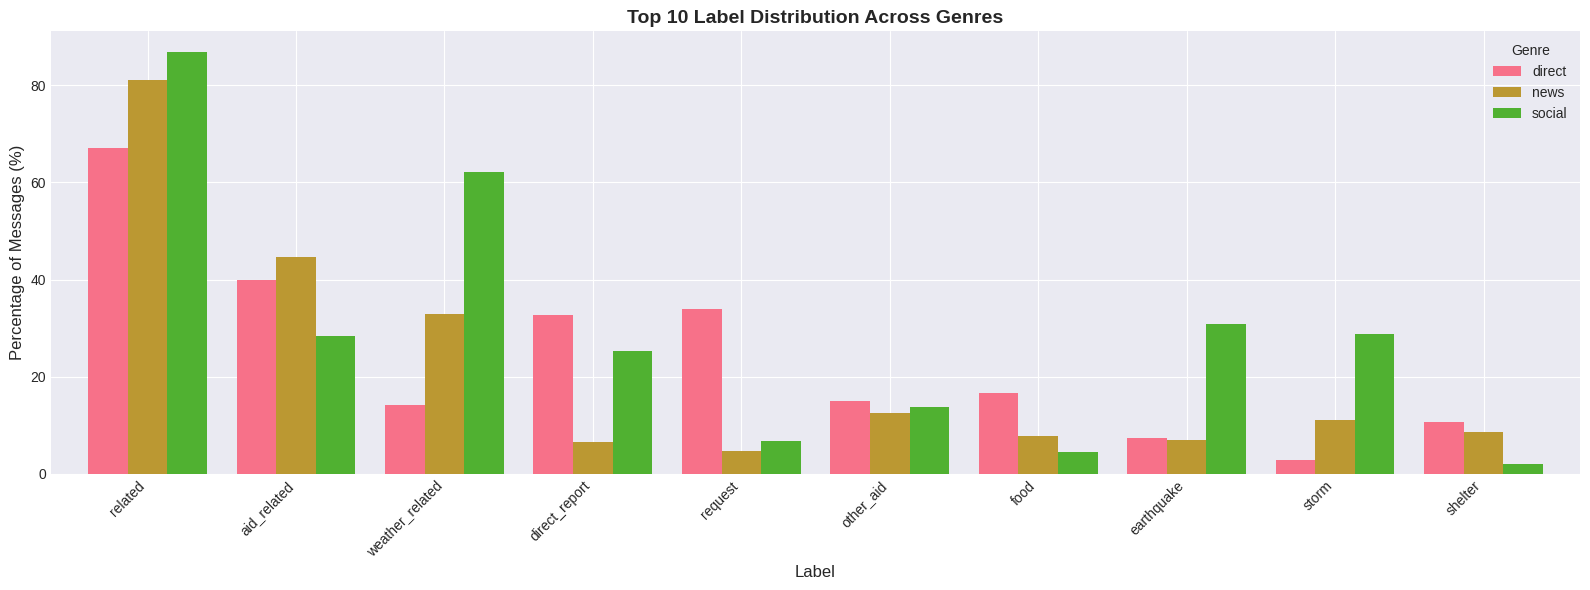

In [22]:
# Visualize top labels by genre
top_10_labels = label_stats.head(10).index
genre_label_dist[top_10_labels].T.plot(
    kind='bar', figsize=(16, 6), width=0.8
)
plt.title('Top 10 Label Distribution Across Genres', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Percentage of Messages (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Genre')
plt.tight_layout()
plt.show()

### 4.7 Critical Categories Analysis

In [23]:
# Define critical categories
critical_categories = ['medical_help', 'water', 'food', 'shelter', 'search_and_rescue']

# Check if they exist in our data
critical_in_data = [cat for cat in critical_categories if cat in label_cols]

print(f"\nCritical categories found in dataset: {critical_in_data}")

# Analyze message characteristics for critical categories
for category in critical_in_data:
    print(f"\n{'-'*60}")
    print(f"Category: {category.upper()}")
    print(f"{'-'*60}")

    positive_msgs = df_train[df_train[category] == 1]

    print(f"Count: {len(positive_msgs)} ({len(positive_msgs)/len(df_train):.2%})")
    print(f"Avg message length: {positive_msgs['message_length'].mean():.1f} chars")
    print(f"Avg word count: {positive_msgs['word_count'].mean():.1f} words")
    print(f"\nSample messages:")
    for i, msg in enumerate(positive_msgs['message'].head(3), 1):
        print(f"  {i}. {msg[:100]}..." if len(msg) > 100 else f"  {i}. {msg}")


Critical categories found in dataset: ['medical_help', 'water', 'food', 'shelter', 'search_and_rescue']

------------------------------------------------------------
Category: MEDICAL_HELP
------------------------------------------------------------
Count: 1653 (7.86%)
Avg message length: 240.6 chars
Avg word count: 38.2 words

Sample messages:
  1. There's nothing to eat and water, we starving and thirsty.
  2. We need food and water in Klecin 12. We are dying of hunger. Impasse Chretien Klecin 12 extended ( e...
  3. People from Dal blocked since Wednesday in Carrefour, we having water shortage, food and medical ass...

------------------------------------------------------------
Category: WATER
------------------------------------------------------------
Count: 1320 (6.28%)
Avg message length: 226.1 chars
Avg word count: 36.7 words

Sample messages:
  1. Please, we need tents and water. We are in Silo, Thank you!
  2. There's nothing to eat and water, we starving and thirsty.
  3. 

### 4.8 Vocabulary Analysis

In [24]:
# Get stopwords
stop_words = set(stopwords.words('english'))

# Overall most common words
all_words = ' '.join(df_train['message'].str.lower()).split()
all_words_filtered = [w for w in all_words if w.isalpha() and w not in stop_words and len(w) > 2]
word_freq = Counter(all_words_filtered)

print("\nTop 30 Most Common Words (excluding stopwords):")
for i, (word, count) in enumerate(word_freq.most_common(30), 1):
    print(f"{i:2d}. {word:20s} : {count:5d}")


Top 30 Most Common Words (excluding stopwords):
 1. people               :  2058
 2. help                 :  1746
 3. water                :  1742
 4. need                 :  1630
 5. food                 :  1613
 6. would                :  1210
 7. like                 :  1207
 8. please               :  1151
 9. earthquake           :  1090
10. also                 :   860
11. know                 :   825
12. one                  :   725
13. find                 :   717
14. said                 :   711
15. government           :   623
16. information          :   598
17. relief               :   594
18. two                  :   573
19. get                  :   570
20. haiti                :   568
21. good                 :   560
22. many                 :   541
23. thank                :   525
24. health               :   515
25. since                :   501
26. areas                :   500
27. affected             :   494
28. new                  :   472
29. aid                  : 

In [25]:
# Most common words per critical category
for category in critical_in_data:
    print(f"Top words for: {category.upper()}")
    print(f"{'='*60}")

    cat_messages = df_train[df_train[category] == 1]['message']
    cat_words = ' '.join(cat_messages.str.lower()).split()
    cat_words_filtered = [w for w in cat_words if w.isalpha() and w not in stop_words and len(w) > 2]
    cat_freq = Counter(cat_words_filtered)

    for i, (word, count) in enumerate(cat_freq.most_common(15), 1):
        print(f"{i:2d}. {word:15s} : {count:4d}")

Top words for: MEDICAL_HELP
 1. people          :  322
 2. water           :  253
 3. health          :  250
 4. medical         :  217
 5. help            :  196
 6. need            :  183
 7. food            :  172
 8. also            :  140
 9. relief          :  110
10. emergency       :  109
11. said            :  105
12. two             :   96
13. earthquake      :   91
14. including       :   91
15. affected        :   89
Top words for: WATER
 1. water           :  930
 2. need            :  367
 3. food            :  329
 4. people          :  255
 5. help            :  183
 6. please          :  136
 7. drinking        :  109
 8. health          :  102
 9. also            :   86
10. medical         :   74
11. sanitation      :   71
12. supplies        :   65
13. clean           :   64
14. relief          :   64
15. affected        :   64
Top words for: FOOD
 1. food            : 1175
 2. need            :  589
 3. people          :  440
 4. water           :  434
 5. help     

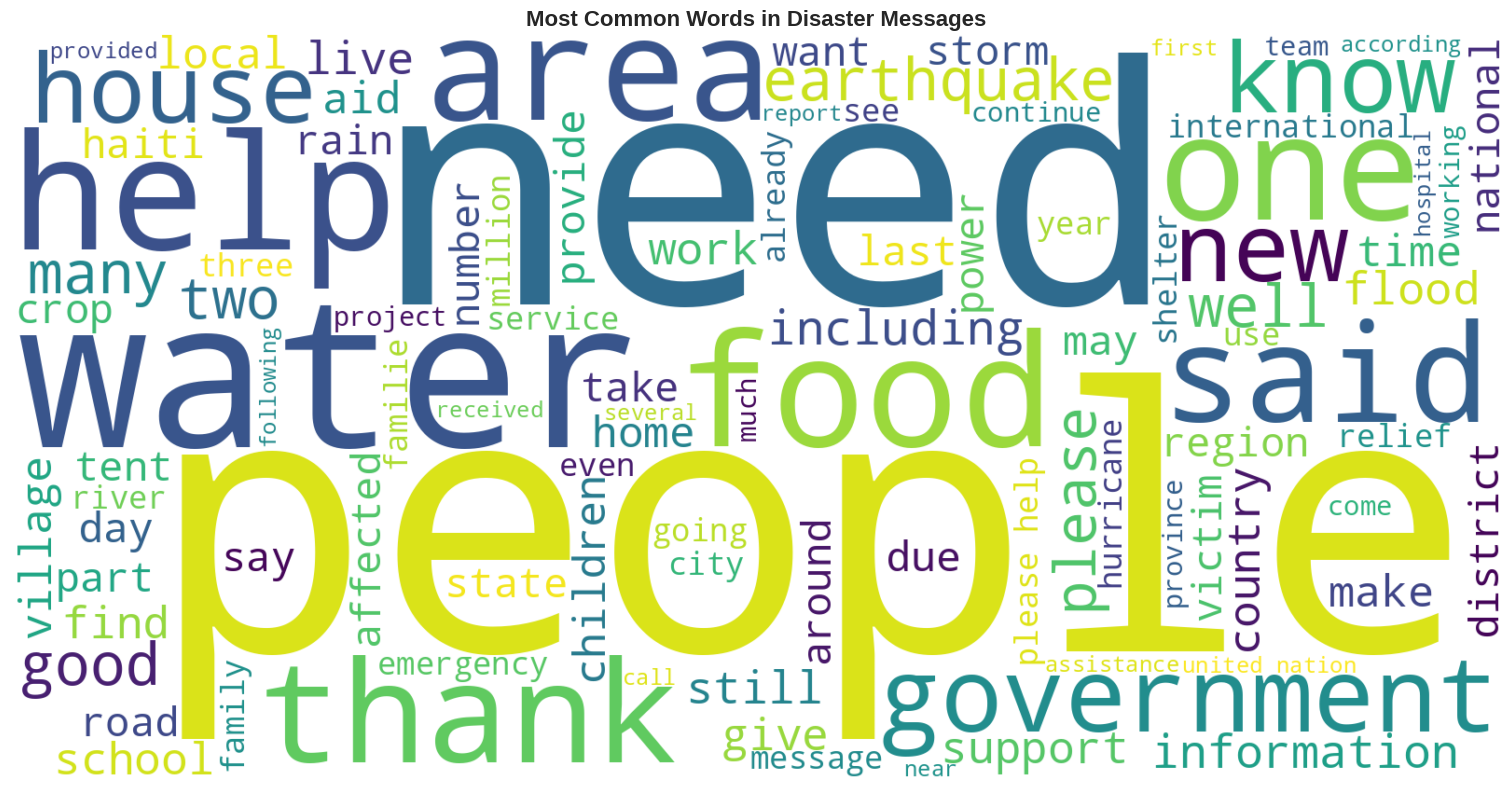

In [26]:
# Visualize word frequencies with word cloud
from wordcloud import WordCloud

# Create word cloud for overall vocabulary
text_for_cloud = ' '.join(all_words_filtered)
wordcloud = WordCloud(width=1600, height=800, background_color='white',
                      max_words=100, colormap='viridis').generate(text_for_cloud)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Disaster Messages', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.9 Train/Validation/Test Split Comparison

In [27]:
# Compare label distributions across splits
splits = {
    'train': df_train,
    'validation': df_val,
    'test': df_test
}

split_comparison = {}
for split_name, split_df in splits.items():
    split_comparison[split_name] = split_df[label_cols].mean() * 100  # Percentage

comparison_df = pd.DataFrame(split_comparison)

print("\nLabel distribution (%) across splits:")
print(comparison_df.head(15))

# Check consistency
print("\nDistribution Consistency Check:")
print("(Values should be similar across splits)")
print("\nStandard deviation across splits for each label:")
std_across_splits = comparison_df.std(axis=1).sort_values(ascending=False)
print(std_across_splits.head(10))


Label distribution (%) across splits:
                       train  validation       test
related            75.835830   75.457021  84.339190
PII                 0.000000    0.000000   0.000000
request            16.911590   16.374951  18.983957
offer               0.000000    0.000000   4.507257
aid_related        41.265991   40.762349  43.353705
medical_help        7.861321    8.284714   8.326967
medical_products    5.093451    5.289771   4.048892
search_and_rescue   2.948590    2.994944   1.031322
security            1.911828    2.100350   0.572956
military            3.157845    3.772851   3.781513
child_alone         0.000000    0.000000   0.000000
water               6.277643    6.106573   7.448434
food               11.057212   10.696227  12.337662
shelter             8.917107    8.206923   8.708938
clothing            1.536120    1.789187   1.375095

Distribution Consistency Check:
(Values should be similar across splits)

Standard deviation across splits for each label:
relat

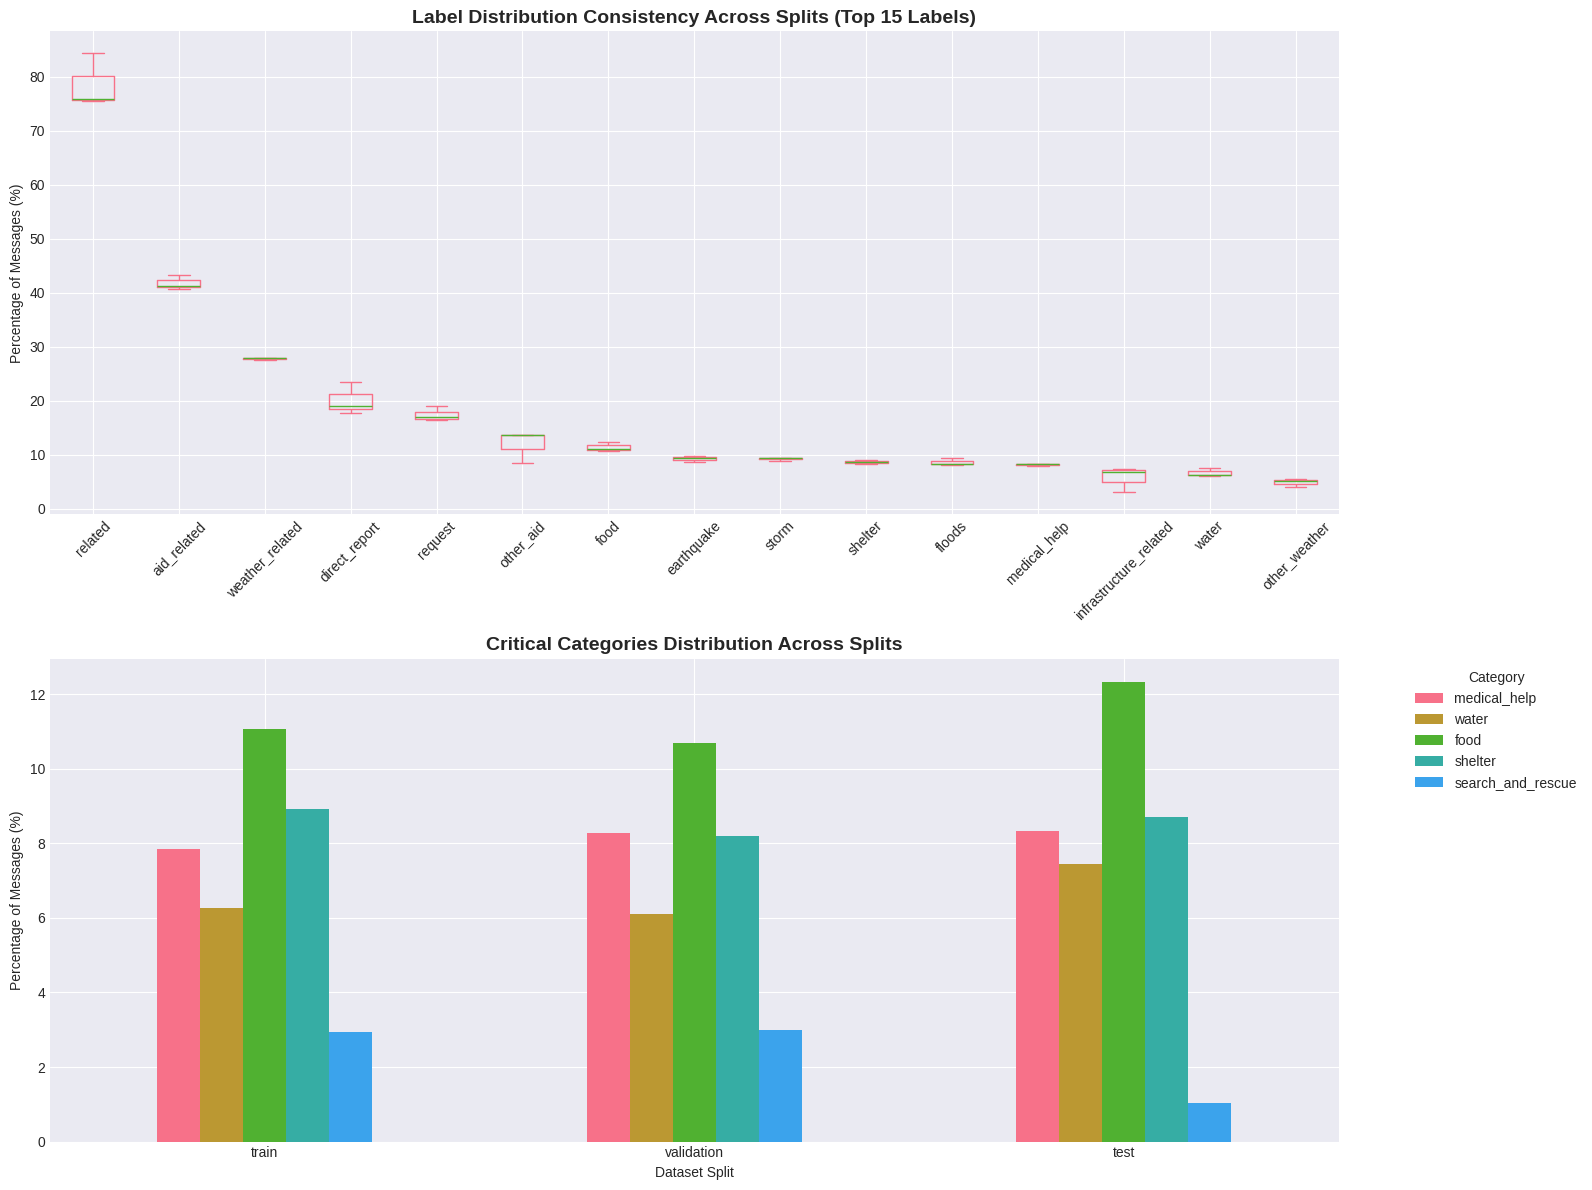

In [28]:
# Visualize split comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Box plot for top 15 labels
top_15_labels = label_stats.head(15).index
comparison_df.loc[top_15_labels].T.plot(kind='box', ax=axes[0])
axes[0].set_title('Label Distribution Consistency Across Splits (Top 15 Labels)',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Percentage of Messages (%)')
axes[0].tick_params(axis='x', rotation=45)

# Bar plot comparison for critical categories
if critical_in_data:
    comparison_df.loc[critical_in_data].T.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Critical Categories Distribution Across Splits',
                      fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Percentage of Messages (%)')
    axes[1].set_xlabel('Dataset Split')
    axes[1].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 5. Advanced Text Preprocessing

In [29]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function for advanced preprocessing
def advanced_preprocess(text):
    """
    Steps:
    1. Lowercase conversion
    2. URL removal
    3. Email removal
    4. Remove special characters (keep letters, numbers, spaces)
    5. Tokenization
    6. Stopword removal
    7. Lemmatization
    8. Remove very short words
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Tokenization
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()

    # Remove stopwords and short words, then lemmatize
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]

    return ' '.join(tokens)

# Test the preprocessing function
sample_msg = df_train['message'].iloc[0]
print(f"\nSample preprocessing:")
print(f"Original: {sample_msg}")
print(f"Cleaned:  {advanced_preprocess(sample_msg)}")


Sample preprocessing:
Original: Weather update - a cold front from Cuba that could pass over Haiti
Cleaned:  weather update cold front cuba could pas haiti


In [30]:
# Apply preprocessing to all datasets
df_train['cleaned_message'] = df_train['message'].apply(advanced_preprocess)
df_val['cleaned_message'] = df_val['message'].apply(advanced_preprocess)
df_test['cleaned_message'] = df_test['message'].apply(advanced_preprocess)

print("Preprocessing complete!")

# Check results
print("\nSample cleaned messages:")
for i in range(5):
    print(f"\n{i+1}. Original: {df_train['message'].iloc[i][:80]}...")
    print(f"   Cleaned:  {df_train['cleaned_message'].iloc[i][:80]}...")

Preprocessing complete!

Sample cleaned messages:

1. Original: Weather update - a cold front from Cuba that could pass over Haiti...
   Cleaned:  weather update cold front cuba could pas haiti...

2. Original: Is the Hurricane over or is it not over...
   Cleaned:  hurricane...

3. Original: says: west side of Haiti, rest of the country today and tonight...
   Cleaned:  say west side haiti rest country today tonight...

4. Original: Information about the National Palace-...
   Cleaned:  information national palace...

5. Original: Storm at sacred heart of jesus...
   Cleaned:  storm sacred heart jesus...


## 6. Feature Engineering

In [31]:
# Function to create additional features from the text
def engineer_features(df):
    df = df.copy()

    # Text length features
    df['message_length'] = df['message'].str.len()
    df['word_count'] = df['message'].str.split().str.len()
    df['avg_word_length'] = df['message_length'] / df['word_count']
    df['cleaned_word_count'] = df['cleaned_message'].str.split().str.len()

    # Punctuation features
    df['exclamation_count'] = df['message'].str.count('!')
    df['question_count'] = df['message'].str.count('\?')
    df['period_count'] = df['message'].str.count('\.')
    df['comma_count'] = df['message'].str.count(',')

    # Content indicators
    df['has_urls'] = df['message'].str.contains(r'http[s]?://', na=False).astype(int)
    df['has_numbers'] = df['message'].str.contains(r'\d+', na=False).astype(int)
    df['has_email'] = df['message'].str.contains(r'\S+@\S+', na=False).astype(int)

    # Capital letters ratio (might indicate urgency)
    df['caps_ratio'] = df['message'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )

    # Genre encoding (will be one-hot encoded later)
    df['genre_encoded'] = pd.Categorical(df['genre']).codes

    return df

# Apply feature engineering
print("\nEngineering features...")
df_train = engineer_features(df_train)
df_val = engineer_features(df_val)
df_test = engineer_features(df_test)

print("Feature engineering complete!")

# Show new features
feature_cols = ['message_length', 'word_count', 'avg_word_length', 'cleaned_word_count',
                'exclamation_count', 'question_count', 'has_urls', 'has_numbers',
                'caps_ratio', 'genre_encoded']

print("\nNew features created:")
print(df_train[feature_cols].head())

print("\nFeature statistics:")
print(df_train[feature_cols].describe())


Engineering features...
Feature engineering complete!

New features created:
   message_length  word_count  avg_word_length  cleaned_word_count  \
0              66          13         5.076923                   8   
1              39           9         4.333333                   1   
2              63          12         5.250000                   8   
3              38           5         7.600000                   3   
4              30           6         5.000000                   4   

   exclamation_count  question_count  has_urls  has_numbers  caps_ratio  \
0                  0               0         0            0    0.045455   
1                  0               0         0            0    0.051282   
2                  0               0         0            0    0.015873   
3                  0               0         0            0    0.078947   
4                  0               0         0            0    0.033333   

   genre_encoded  
0              0  
1           

## 7. Final Data Preparation for Modeling

In [32]:
# Define feature columns and label columns
text_feature = 'cleaned_message'
categorical_features = ['genre']
numerical_features = ['message_length', 'word_count', 'avg_word_length',
                      'exclamation_count', 'question_count', 'caps_ratio']

# Separate features (X) and labels (y)
X_train = df_train[[text_feature] + categorical_features]
y_train = df_train[label_cols]

X_val = df_val[[text_feature] + categorical_features]
y_val = df_val[label_cols]

X_test = df_test[[text_feature] + categorical_features]
y_test = df_test[label_cols]

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

print(f"\nLabel matrix shapes:")
print(f"  y_train: {y_train.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  y_test:  {y_test.shape}")


Feature matrix shapes:
  X_train: (21027, 2)
  X_val:   (2571, 2)
  X_test:  (2618, 2)

Label matrix shapes:
  y_train: (21027, 37)
  y_val:   (2571, 37)
  y_test:  (2618, 37)


In [33]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),  # unigrams and bigrams
            min_df=2,  # ignore terms that appear in less than 2 documents
            max_df=0.8  # ignore terms that appear in more than 80% of documents
        ), text_feature),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out=False
)

# Fit and transform
print("\nFitting preprocessor on training data...")
X_train_processed = preprocessor.fit_transform(X_train)

print("Transforming validation and test data...")
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"\nPreprocessing complete!")
print(f"\nProcessed feature matrix shapes:")
print(f"  X_train_processed: {X_train_processed.shape}")
print(f"  X_val_processed:   {X_val_processed.shape}")
print(f"  X_test_processed:  {X_test_processed.shape}")
print(f"\nMatrix type: {type(X_train_processed)}")
print(f"Matrix sparsity: {1 - (X_train_processed.nnz / (X_train_processed.shape[0] * X_train_processed.shape[1])):.2%}")


Fitting preprocessor on training data...
Transforming validation and test data...

Preprocessing complete!

Processed feature matrix shapes:
  X_train_processed: (21027, 5003)
  X_val_processed:   (2571, 5003)
  X_test_processed:  (2618, 5003)

Matrix type: <class 'scipy.sparse._csr.csr_matrix'>
Matrix sparsity: 99.74%


In [34]:
# Also create numpy versions for easier use
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

## 8. Save Processed Data

In [35]:
import pickle

# Create output directory
output_dir = '/content/processed_data/'
os.makedirs(output_dir, exist_ok=True)

# Save cleaned dataframes
print("\nSaving cleaned datasets:")
df_train.to_csv(f'{output_dir}disaster_train_cleaned.csv', index=False)
df_val.to_csv(f'{output_dir}disaster_val_cleaned.csv', index=False)
df_test.to_csv(f'{output_dir}disaster_test_cleaned.csv', index=False)

# Save preprocessor
print("Saving preprocessor:")
with open(f'{output_dir}preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save processed features and labels
print("Saving processed features and labels:")
from scipy.sparse import save_npz

save_npz(f'{output_dir}X_train_processed.npz', X_train_processed)
save_npz(f'{output_dir}X_val_processed.npz', X_val_processed)
save_npz(f'{output_dir}X_test_processed.npz', X_test_processed)

y_train.to_csv(f'{output_dir}y_train.csv', index=False)
y_val.to_csv(f'{output_dir}y_val.csv', index=False)
y_test.to_csv(f'{output_dir}y_test.csv', index=False)

# Save label names for reference
with open(f'{output_dir}label_names.txt', 'w') as f:
    f.write('\n'.join(label_cols))

print(f"\nAll data saved to: {output_dir}")
print(f"\nFiles created:")
for file in os.listdir(output_dir):
    print(f"  - {file}")


Saving cleaned datasets:
Saving preprocessor:
Saving processed features and labels:

All data saved to: /content/processed_data/

Files created:
  - disaster_val_cleaned.csv
  - label_names.txt
  - X_val_processed.npz
  - disaster_train_cleaned.csv
  - preprocessor.pkl
  - y_val.csv
  - y_train.csv
  - y_test.csv
  - disaster_test_cleaned.csv
  - X_test_processed.npz
  - X_train_processed.npz


### EDA SUMMARY & KEY FINDINGS

In [36]:
print("\n1. DATASET OVERVIEW")
print(f"   - Training samples: {len(df_train):,}")
print(f"   - Validation samples: {len(df_val):,}")
print(f"   - Test samples: {len(df_test):,}")
print(f"   - Total labels: {len(label_cols)}")

print("\n2. GENRE DISTRIBUTION")
for genre, pct in df_train['genre'].value_counts(normalize=True).items():
    print(f"   - {genre}: {pct:.1%}")

print("\n3. LABEL DISTRIBUTION")
print(f"   - Most common label: {label_stats.index[0]} ({label_stats['positive_pct'].iloc[0]:.1f}%)")
print(f"   - Rarest label: {label_stats.index[-1]} ({label_stats['positive_pct'].iloc[-1]:.1f}%)")
print(f"   - Labels with <5% prevalence: {len(severe_imbalance)}")
print(f"   - Labels with <10% prevalence: {len(severe_imbalance) + len(moderate_imbalance)}")

print("\n4. MULTI-LABEL CHARACTERISTICS")
print(f"   - Avg labels per message: {df_train['label_count'].mean():.2f}")
print(f"   - Messages with no labels: {(df_train['label_count'] == 0).sum()/len(df_train):.1%}")
print(f"   - Messages with multiple labels: {(df_train['label_count'] > 1).sum()/len(df_train):.1%}")

print("\n5. MESSAGE CHARACTERISTICS")
print(f"   - Avg message length: {df_train['message_length'].mean():.1f} characters")
print(f"   - Avg word count: {df_train['word_count'].mean():.1f} words")
print(f"   - Messages with URLs: {df_train['has_urls'].sum()/len(df_train):.1%}")


1. DATASET OVERVIEW
   - Training samples: 21,027
   - Validation samples: 2,571
   - Test samples: 2,618
   - Total labels: 37

2. GENRE DISTRIBUTION
   - news: 49.7%
   - direct: 41.1%
   - social: 9.2%

3. LABEL DISTRIBUTION
   - Most common label: related (75.8%)
   - Rarest label: child_alone (0.0%)
   - Labels with <5% prevalence: 20
   - Labels with <10% prevalence: 30

4. MULTI-LABEL CHARACTERISTICS
   - Avg labels per message: 3.17
   - Messages with no labels: 24.2%
   - Messages with multiple labels: 55.8%

5. MESSAGE CHARACTERISTICS
   - Avg message length: 143.9 characters
   - Avg word count: 23.7 words
   - Messages with URLs: 2.6%


## Key Insights:



*   Severe class imbalance, will need to use SMOTE/class weights
*   High label correlatio: Classifier Chains may outperform Binary Relevance
*   24% unlabeled messages that may need to be filtered or handle separately
*   Consistent split distributions: good data partitioning
*   Rich vocabulary: TF-IDF should capture semantic differences



## 9. Utility Functions for Evaluation

In [37]:
# Function for comprehensive eval for multi-label classification; returns dictionary all metrics
def evaluate_multilabel_model(y_true, y_pred, label_names, model_name="Model", verbose=True):
    results = {}

    # Overall metrics
    results['hamming_loss'] = hamming_loss(y_true, y_pred)
    results['subset_accuracy'] = accuracy_score(y_true, y_pred)
    results['f1_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=0)
    results['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    results['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    results['precision_micro'] = precision_score(y_true, y_pred, average='micro', zero_division=0)
    results['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    results['recall_micro'] = recall_score(y_true, y_pred, average='micro', zero_division=0)
    results['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)

    # Per-label metrics
    f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
    precision_per_label = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_label = recall_score(y_true, y_pred, average=None, zero_division=0)

    results['per_label_metrics'] = pd.DataFrame({
        'Label': label_names,
        'F1': f1_per_label,
        'Precision': precision_per_label,
        'Recall': recall_per_label,
        'Support': y_true.sum(axis=0) if hasattr(y_true, 'sum') else y_true.sum()
    })

    if verbose:
        print("\n Overall Metrics:")
        print(f"  Hamming Loss:      {results['hamming_loss']:.4f} (lower is better)")
        print(f"  Subset Accuracy:   {results['subset_accuracy']:.4f} (exact match)")
        print(f"  F1-Score (Micro):  {results['f1_micro']:.4f}")
        print(f"  F1-Score (Macro):  {results['f1_macro']:.4f}")
        print(f"  F1-Score (Weighted): {results['f1_weighted']:.4f}")
        print(f"  Precision (Micro): {results['precision_micro']:.4f}")
        print(f"  Recall (Micro):    {results['recall_micro']:.4f}")

        print("\n Top 10 Labels by F1-Score:")
        top_labels = results['per_label_metrics'].nlargest(10, 'F1')[['Label', 'F1', 'Precision', 'Recall', 'Support']]
        print(top_labels.to_string(index=False))

        print("\n  Bottom 10 Labels by F1-Score:")
        bottom_labels = results['per_label_metrics'].nsmallest(10, 'F1')[['Label', 'F1', 'Precision', 'Recall', 'Support']]
        print(bottom_labels.to_string(index=False))

        # Critical categories performance
        critical_in_labels = [cat for cat in critical_categories if cat in label_names]
        if critical_in_labels:
            print("\n Critical Categories Performance:")
            critical_metrics = results['per_label_metrics'][results['per_label_metrics']['Label'].isin(critical_in_labels)]
            print(critical_metrics[['Label', 'F1', 'Precision', 'Recall', 'Support']].to_string(index=False))

    return results

# Function to plot comparison of different models
def plot_model_comparison(results_dict, metric='f1_micro'):
    models = list(results_dict.keys())
    scores = [results_dict[model][metric] for model in models]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(models, scores, color='steelblue', edgecolor='black')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel(f'{metric.replace("_", " ").title()}', fontsize=12)
    plt.title(f'Model Comparison - {metric.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Function to visualize per-label performance
def plot_per_label_performance(results, top_n=15):
    per_label = results['per_label_metrics'].sort_values('F1', ascending=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Top performers
    top = per_label.head(top_n)
    top[['F1', 'Precision', 'Recall']].plot(kind='barh', ax=ax1)
    ax1.set_yticks(range(len(top)))
    ax1.set_yticklabels(top['Label'])
    ax1.set_xlabel('Score')
    ax1.set_title(f'Top {top_n} Labels by F1-Score', fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.set_xlim(0, 1)

    # Bottom performers
    bottom = per_label.tail(top_n)
    bottom[['F1', 'Precision', 'Recall']].plot(kind='barh', ax=ax2)
    ax2.set_yticks(range(len(bottom)))
    ax2.set_yticklabels(bottom['Label'])
    ax2.set_xlabel('Score')
    ax2.set_title(f'Bottom {top_n} Labels by F1-Score', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

print(" Utility functions defined!")

 Utility functions defined!


## 10. Model Training - 3 Approaches

We'll train the 3 most effective models:
1. **XGBoost**: Powerful gradient boosting with binary relevance
2. **Classifier Chains**: Captures label dependencies
3. **Deep Neural Network**: With threshold tuning for optimal performance

In [38]:
# Initialize results dictionary
all_results = {}
print("\n1. XGBoost (Binary Relevance)")
print("2. Classifier Chains (Label Dependencies)")
print("3. Deep Neural Network (Threshold Tuned)")


1. XGBoost (Binary Relevance)
2. Classifier Chains (Label Dependencies)
3. Deep Neural Network (Threshold Tuned)


## 11. [Model 1] Classifier Chains: Capturing Label Dependencies

In [39]:
import time
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, precision_score, recall_score

print("\nClassifier Chains model label dependencies for better predictions.")
print("Training...")
start_time = time.time()

# Identify labels with only one class in the training data
one_class_labels = y_train.columns[(y_train.sum(axis=0) == 0) | (y_train.sum(axis=0) == len(y_train))]
print(f"\nRemoving {len(one_class_labels)} labels with only one class in training data: {list(one_class_labels)}")

# Drop these labels from the training and validation sets
y_train_filtered = y_train.drop(columns=one_class_labels)
y_val_filtered = y_val.drop(columns=one_class_labels)

# Update label_cols to reflect the labels being used
filtered_label_cols = [col for col in label_cols if col not in one_class_labels]

# Create model
chain_model = ClassifierChain(
    LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs',
        random_state=42
    ),
    order='random',
    random_state=42
)

# Train on processed data with filtered labels
chain_model.fit(X_train_processed, y_train_filtered)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Predictions on processed data
print("\nMaking predictions...")
y_pred_chain_val = chain_model.predict(X_val_processed)

# Evaluate using filtered labels
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE")
results_chain_val = evaluate_multilabel_model(
    y_val_filtered, y_pred_chain_val, filtered_label_cols,
    model_name="Classifier Chains (LR)"
)

# Store results
all_results['Classifier_Chains'] = results_chain_val


Classifier Chains model label dependencies for better predictions.
Training...

Removing 3 labels with only one class in training data: ['PII', 'offer', 'child_alone']
Training completed in 11.23 seconds

Making predictions...

VALIDATION SET PERFORMANCE

 Overall Metrics:
  Hamming Loss:      0.1581 (lower is better)
  Subset Accuracy:   0.2532 (exact match)
  F1-Score (Micro):  0.4662
  F1-Score (Macro):  0.3448
  F1-Score (Weighted): 0.5908
  Precision (Micro): 0.3391
  Recall (Micro):    0.7459

 Top 10 Labels by F1-Score:
          Label       F1  Precision   Recall  Support
        related 0.852015   0.917360 0.795361     1940
weather_related 0.747209   0.697304 0.804809      707
     earthquake 0.731624   0.636905 0.859438      249
    aid_related 0.693912   0.616296 0.793893     1048
           food 0.671408   0.551402 0.858182      275
          storm 0.631380   0.577855 0.695833      240
          water 0.622222   0.508065 0.802548      157
        request 0.527975   0.39504

## 12. [Model 2] XGBoost with Binary Relevance

In [40]:
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import time # Import time for timing
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, precision_score, recall_score # Import metrics

print("\nTraining XGBoost model...")
start_time = time.time()

# Identify labels with only one class in the training data
one_class_labels = y_train.columns[(y_train.sum(axis=0) == 0) | (y_train.sum(axis=0) == len(y_train))]
print(f"\nRemoving {len(one_class_labels)} labels with only one class in training data: {list(one_class_labels)}")

# Drop these labels from the training and validation sets
y_train_filtered = y_train.drop(columns=one_class_labels)
y_val_filtered = y_val.drop(columns=one_class_labels)

# Update label_cols to reflect the labels being used
filtered_label_cols = [col for col in label_cols if col not in one_class_labels]


# Create model
xgb_model = MultiOutputClassifier(
    XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
)

# Train on processed data with filtered labels
xgb_model.fit(X_train_processed, y_train_filtered)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")

# Predictions on processed data
print("\nMaking predictions...")
y_pred_xgb_val = xgb_model.predict(X_val_processed)

# Evaluate using filtered labels
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE")
results_xgb_val = evaluate_multilabel_model(
    y_val_filtered, y_pred_xgb_val, filtered_label_cols,
    model_name="XGBoost (Binary Relevance)"
)

# Store results
all_results['XGBoost'] = results_xgb_val


Training XGBoost model...

Removing 3 labels with only one class in training data: ['PII', 'offer', 'child_alone']
Training completed in 153.00 seconds

Making predictions...

VALIDATION SET PERFORMANCE

 Overall Metrics:
  Hamming Loss:      0.0524 (lower is better)
  Subset Accuracy:   0.2956 (exact match)
  F1-Score (Micro):  0.6759
  F1-Score (Macro):  0.4222
  F1-Score (Weighted): 0.6333
  Precision (Micro): 0.7903
  Recall (Micro):    0.5904

 Top 10 Labels by F1-Score:
          Label       F1  Precision   Recall  Support
        related 0.879830   0.810330 0.962371     1940
     earthquake 0.850526   0.893805 0.811245      249
           food 0.780847   0.791045 0.770909      275
weather_related 0.758340   0.892720 0.659123      707
          water 0.737931   0.804511 0.681529      157
          storm 0.709677   0.793814 0.641667      240
    aid_related 0.677005   0.770073 0.604008     1048
        shelter 0.663073   0.768750 0.582938      211
        request 0.656676   0.769

## 13. [Model 3] Deep Neural Network: Multi-Label Classification

In [41]:
# Convert sparse matrices to dense for neural network
print("\nConverting sparse matrices to dense...")
X_train_dense = X_train_processed.toarray()
X_val_dense = X_val_processed.toarray()

# Convert labels to numpy arrays
y_train_np = y_train.values
y_val_np = y_val.values

n_features = X_train_dense.shape[1]
n_labels = y_train_np.shape[1]

print(f"Input features: {n_features}")
print(f"Output labels: {n_labels}")


Converting sparse matrices to dense...
Input features: 5003
Output labels: 37


In [42]:
# Build neural network
def build_multilabel_nn(input_dim, output_dim):
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),

        # Hidden layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Output layer - sigmoid for multi-label
        layers.Dense(output_dim, activation='sigmoid')
    ])

    return model

# Create model
nn_model = build_multilabel_nn(n_features, n_labels)

# Compile model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary cross-entropy for multi-label
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("\nModel architecture:")
nn_model.summary()


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,562,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,734,629 (10.43 MB)

 Trainable params: 2,732,837 (10.42 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [43]:
# Train neural network
print("\nTraining neural network...")
# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Train
history = nn_model.fit(
    X_train_dense, y_train_np,
    validation_data=(X_val_dense, y_val_np),
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")


Training neural network...
Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6220 - loss: 0.6881 - precision: 0.1274 - recall: 0.5516 - val_accuracy: 0.9287 - val_loss: 0.2405 - val_precision: 0.7546 - val_recall: 0.2397 - learning_rate: 0.0010
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9423 - loss: 0.1909 - precision: 0.7574 - recall: 0.4845 - val_accuracy: 0.9300 - val_loss: 0.1959 - val_precision: 0.7816 - val_recall: 0.2467 - learning_rate: 0.0010
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9501 - loss: 0.1483 - precision: 0.8121 - recall: 0.5505 - val_accuracy: 0.9375 - val_loss: 0.1697 - val_precision: 0.8345 - val_recall: 0.3314 - learning_rate: 0.0010
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9558 - loss: 0.1277 - precision: 0.8276 - recall: 0.6090 - val_accuracy: 0.9462 - val_loss: 0.1539 - val_precision: 0.8364 - val_recall: 0.4566 - learning_rate: 0.0010
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━

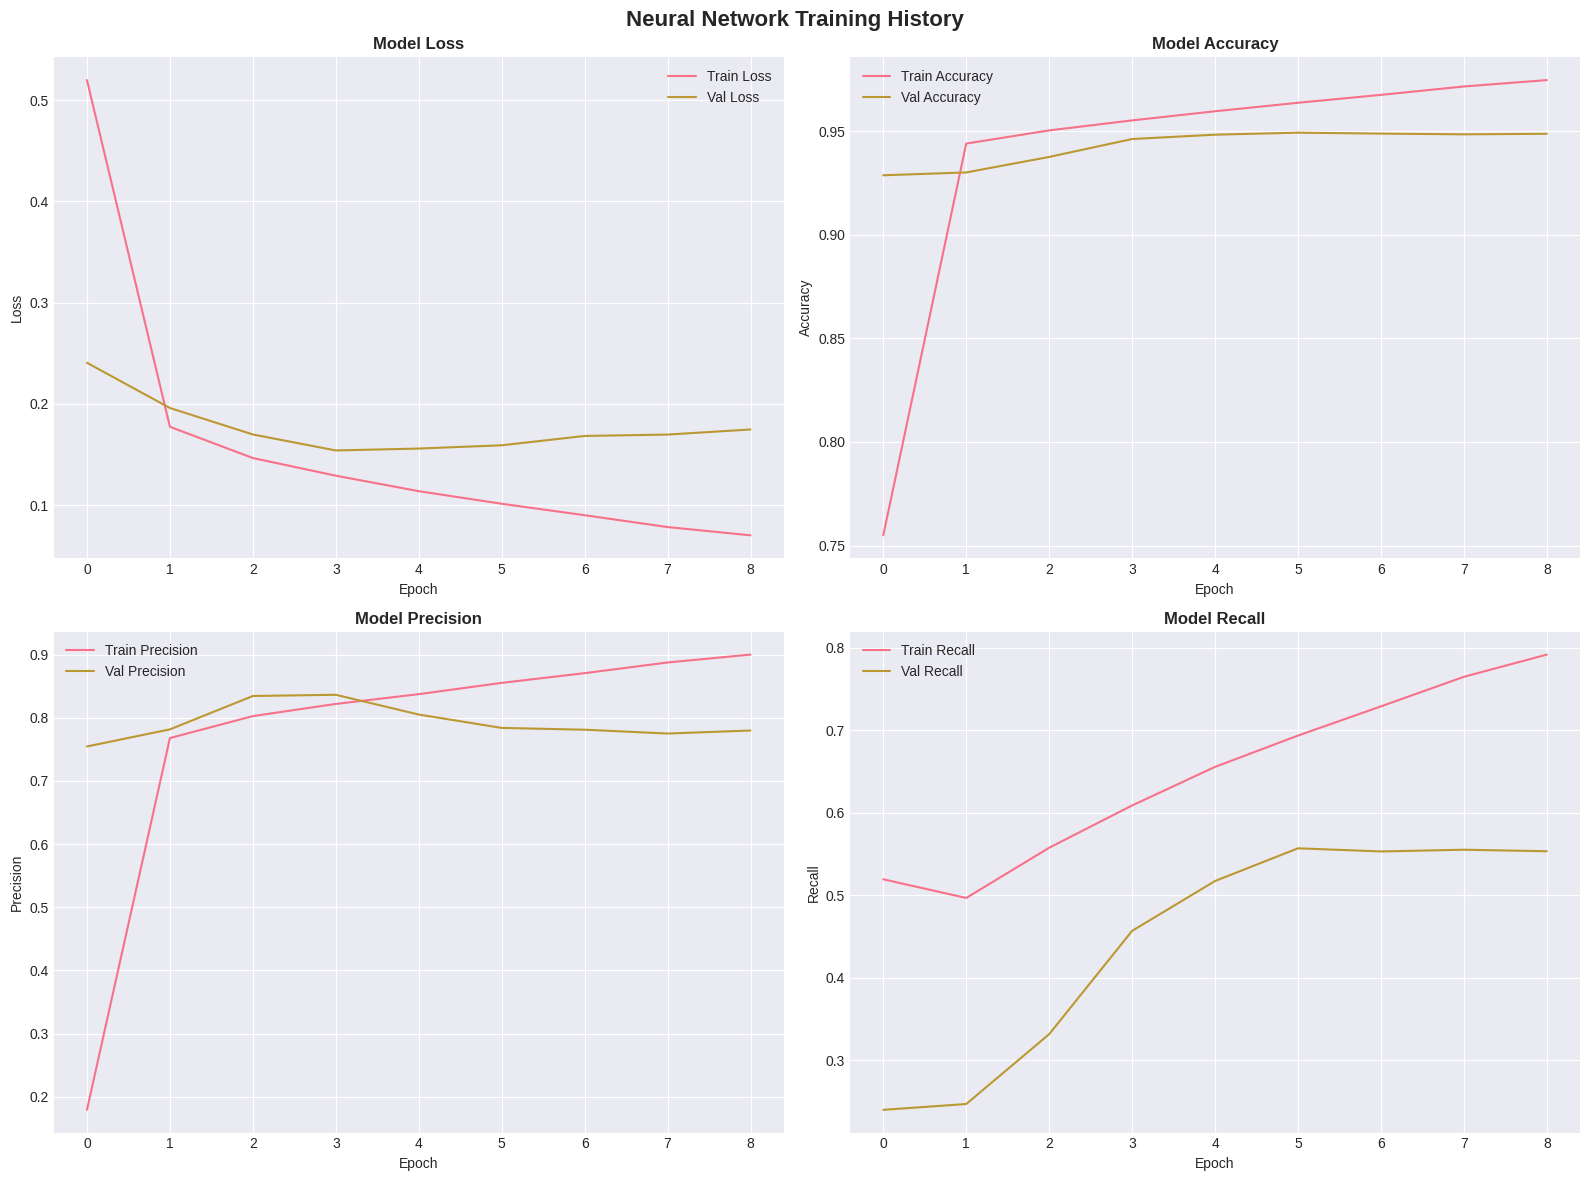

In [44]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Model Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Model Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Model Precision', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Model Recall', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.suptitle('Neural Network Training History', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [45]:
# Make predictions with neural network
print("\nMaking predictions...")
y_pred_nn_val_proba = nn_model.predict(X_val_dense)
y_pred_nn_val = (y_pred_nn_val_proba > 0.5).astype(int)  # Threshold at 0.5

# Process label names

file_path = os.path.join('processed_data', 'label_names.txt')

# List to hold the extracted label names
label_names = []

try:
    # Use 'with open' to ensure the file is properly closed, even if errors occur
    with open(file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()

        for line in lines:
            # .strip() removes any leading/trailing whitespace, including the newline character
            label = line.strip()

            # Only add non-empty lines (in case there are blank lines in the file)
            if label:
                label_names.append(label)

except Exception as e:
    print(f"Life goes hard sometimes: {e}")

# Evaluate

print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE")
results_nn_val = evaluate_multilabel_model(
    y_val_np, y_pred_nn_val, label_names,
    model_name="Deep Neural Network"
)

# Store results
all_results['Neural_Network'] = results_nn_val


Making predictions...
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

VALIDATION SET PERFORMANCE

 Overall Metrics:
  Hamming Loss:      0.0538 (lower is better)
  Subset Accuracy:   0.3112 (exact match)
  F1-Score (Micro):  0.5907
  F1-Score (Macro):  0.2048
  F1-Score (Weighted): 0.5244
  Precision (Micro): 0.8364
  Recall (Micro):    0.4566

 Top 10 Labels by F1-Score:
          Label       F1  Precision   Recall  Support
        related 0.886012   0.872936 0.899485     1940
     earthquake 0.656331   0.920290 0.510040      249
weather_related 0.648649   0.893300 0.509194      707
    aid_related 0.636617   0.763685 0.545802     1048
        request 0.625731   0.813688 0.508314      421
  direct_report 0.557880   0.769231 0.437637      457
           food 0.546763   0.802817 0.414545      275
          water 0.511211   0.863636 0.363057      157
        shelter 0.471380   0.813953 0.331754      211
         floods 0.452297   0.927536 0.299065      214

  Bottom 10 Labels by F1-Score:
     

## 14. Threshold Tuning for Neural Network

In [46]:
# Find optimal decision thresholds for each label
optimal_thresholds = {}
threshold_range = np.arange(0.1, 0.9, 0.05)

for i, label in enumerate(label_names):
    best_f1 = 0
    best_threshold = 0.5

    for threshold in threshold_range:
        predictions = (y_pred_nn_val_proba[:, i] > threshold).astype(int)
        f1 = f1_score(y_val_np[:, i], predictions, zero_division=0)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    optimal_thresholds[label] = {
        'threshold': best_threshold,
        'f1_score': best_f1
    }

print(" Optimal thresholds found!")

# Show thresholds for critical categories
print("\nOptimal thresholds for critical categories:")
for cat in critical_in_data:
    if cat in optimal_thresholds:
        print(f"  {cat:20s}: {optimal_thresholds[cat]['threshold']:.2f} (F1: {optimal_thresholds[cat]['f1_score']:.3f})")

# Apply optimal thresholds
print("\nApplying optimal thresholds...")
y_pred_nn_tuned = np.zeros_like(y_pred_nn_val_proba)
for i, label in enumerate(label_names):
    threshold = optimal_thresholds[label]['threshold']
    y_pred_nn_tuned[:, i] = (y_pred_nn_val_proba[:, i] > threshold).astype(int)

# Evaluate with tuned thresholds
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE (THRESHOLD TUNED)")
results_nn_tuned_val = evaluate_multilabel_model(
    y_val_np, y_pred_nn_tuned, label_names,
    model_name="Neural Network (Threshold Tuned)"
)

# Store results
all_results['NN_Threshold_Tuned'] = results_nn_tuned_val

 Optimal thresholds found!

Optimal thresholds for critical categories:
  medical_help        : 0.10 (F1: 0.443)
  water               : 0.15 (F1: 0.654)
  food                : 0.15 (F1: 0.721)
  shelter             : 0.15 (F1: 0.639)
  search_and_rescue   : 0.10 (F1: 0.228)

Applying optimal thresholds...

VALIDATION SET PERFORMANCE (THRESHOLD TUNED)

 Overall Metrics:
  Hamming Loss:      0.0610 (lower is better)
  Subset Accuracy:   0.2828 (exact match)
  F1-Score (Micro):  0.6502
  F1-Score (Macro):  0.3776
  F1-Score (Weighted): 0.6480
  Precision (Micro): 0.6344
  Recall (Micro):    0.6668

 Top 10 Labels by F1-Score:
          Label       F1  Precision   Recall  Support
        related 0.888944   0.861635 0.918041     1940
     earthquake 0.793926   0.863208 0.734940      249
weather_related 0.736766   0.755952 0.718529      707
           food 0.721014   0.718412 0.723636      275
    aid_related 0.715296   0.666392 0.771947     1048
        request 0.684729   0.710997 0.66033

## 15. Model Comparison

In [47]:
# Create comparison dataframe
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Hamming Loss': results['hamming_loss'],
        'Subset Accuracy': results['subset_accuracy'],
        'F1 (Micro)': results['f1_micro'],
        'F1 (Macro)': results['f1_macro'],
        'F1 (Weighted)': results['f1_weighted'],
        'Precision (Micro)': results['precision_micro'],
        'Recall (Micro)': results['recall_micro']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1 (Micro)', ascending=False)

print("\n Overall Performance Comparison:")
print(comparison_df.to_string(index=False))

# Identify best model
best_model = comparison_df.iloc[0]['Model']
print(f"\n Best Model: {best_model}")
print(f"   F1-Score (Micro): {comparison_df.iloc[0]['F1 (Micro)']:.4f}")


 Overall Performance Comparison:
             Model  Hamming Loss  Subset Accuracy  F1 (Micro)  F1 (Macro)  F1 (Weighted)  Precision (Micro)  Recall (Micro)
           XGBoost      0.052429         0.295605    0.675907    0.422189       0.633339           0.790309        0.590437
NN_Threshold_Tuned      0.061045         0.282769    0.650202    0.377640       0.647966           0.634419        0.666790
    Neural_Network      0.053833         0.311163    0.590746    0.204777       0.524364           0.836388        0.456635
 Classifier_Chains      0.158144         0.253209    0.466214    0.344796       0.590762           0.339081        0.745861

 Best Model: XGBoost
   F1-Score (Micro): 0.6759


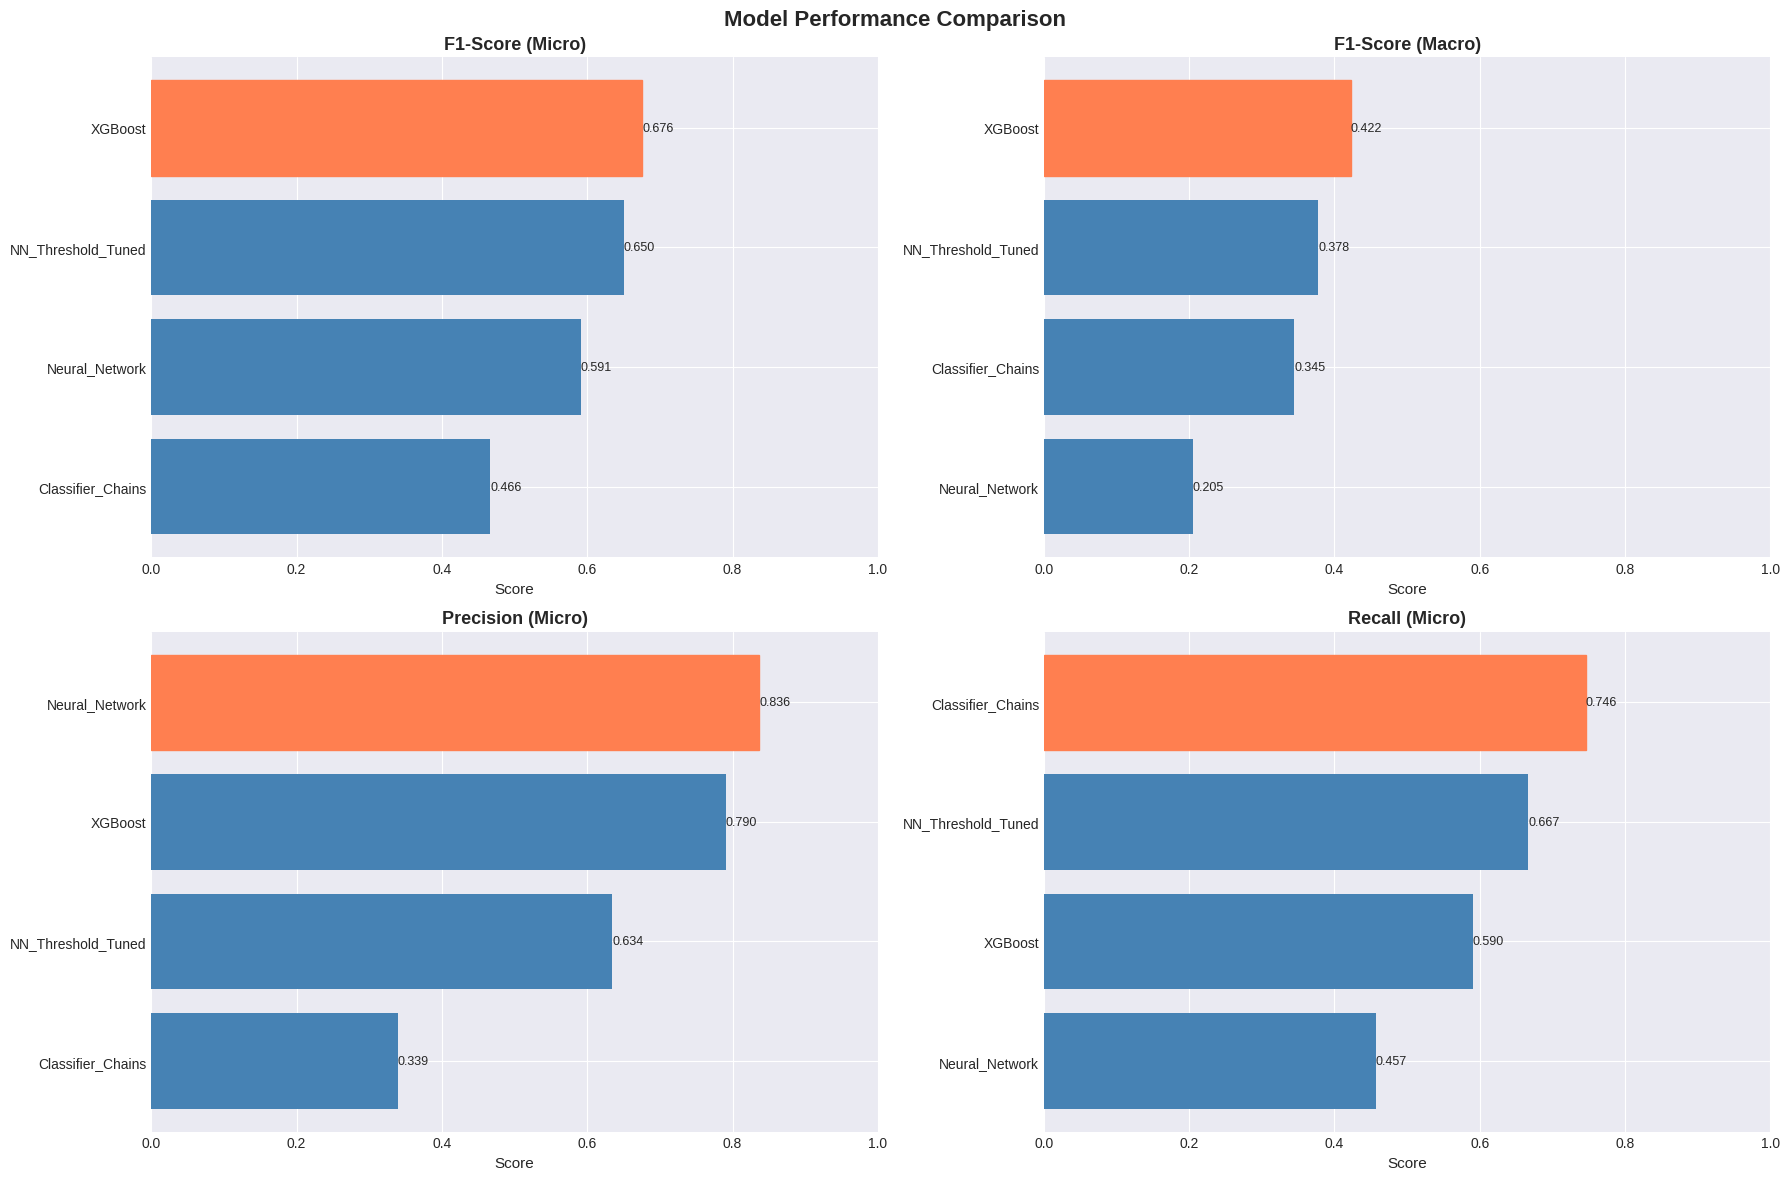

In [48]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

metrics_to_plot = ['F1 (Micro)', 'F1 (Macro)', 'Precision (Micro)', 'Recall (Micro)']
titles = ['F1-Score (Micro)', 'F1-Score (Macro)', 'Precision (Micro)', 'Recall (Micro)']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]

    data = comparison_df.sort_values(metric, ascending=True)
    bars = ax.barh(data['Model'], data[metric], color='steelblue')

    # Color the best bar differently
    bars[-1].set_color('coral')

    ax.set_xlabel('Score', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 16. Critical Categories Analysis

In [49]:
# Extract critical category performance for each model
critical_comparison = []

for model_name, results in all_results.items():
    per_label = results['per_label_metrics']
    critical_metrics = per_label[per_label['Label'].isin(critical_in_data)]

    for _, row in critical_metrics.iterrows():
        critical_comparison.append({
            'Model': model_name,
            'Category': row['Label'],
            'F1': row['F1'],
            'Precision': row['Precision'],
            'Recall': row['Recall']
        })

critical_df = pd.DataFrame(critical_comparison)

# Pivot for easier viewing
for category in critical_in_data:
    print(f"\n{'='*60}")
    print(f"Category: {category.upper()}")
    print(f"{'='*60}")

    cat_data = critical_df[critical_df['Category'] == category][['Model', 'F1', 'Precision', 'Recall']]
    cat_data = cat_data.sort_values('F1', ascending=False)
    print(cat_data.to_string(index=False))


Category: MEDICAL_HELP
             Model       F1  Precision   Recall
NN_Threshold_Tuned 0.443203   0.367284 0.558685
           XGBoost 0.429487   0.676768 0.314554
 Classifier_Chains 0.304740   0.200594 0.633803
    Neural_Network 0.143460   0.708333 0.079812

Category: WATER
             Model       F1  Precision   Recall
           XGBoost 0.737931   0.804511 0.681529
NN_Threshold_Tuned 0.654206   0.640244 0.668790
 Classifier_Chains 0.622222   0.508065 0.802548
    Neural_Network 0.511211   0.863636 0.363057

Category: FOOD
             Model       F1  Precision   Recall
           XGBoost 0.780847   0.791045 0.770909
NN_Threshold_Tuned 0.721014   0.718412 0.723636
 Classifier_Chains 0.671408   0.551402 0.858182
    Neural_Network 0.546763   0.802817 0.414545

Category: SHELTER
             Model       F1  Precision   Recall
           XGBoost 0.663073   0.768750 0.582938
NN_Threshold_Tuned 0.639485   0.584314 0.706161
 Classifier_Chains 0.520301   0.381057 0.819905
    Neural_N

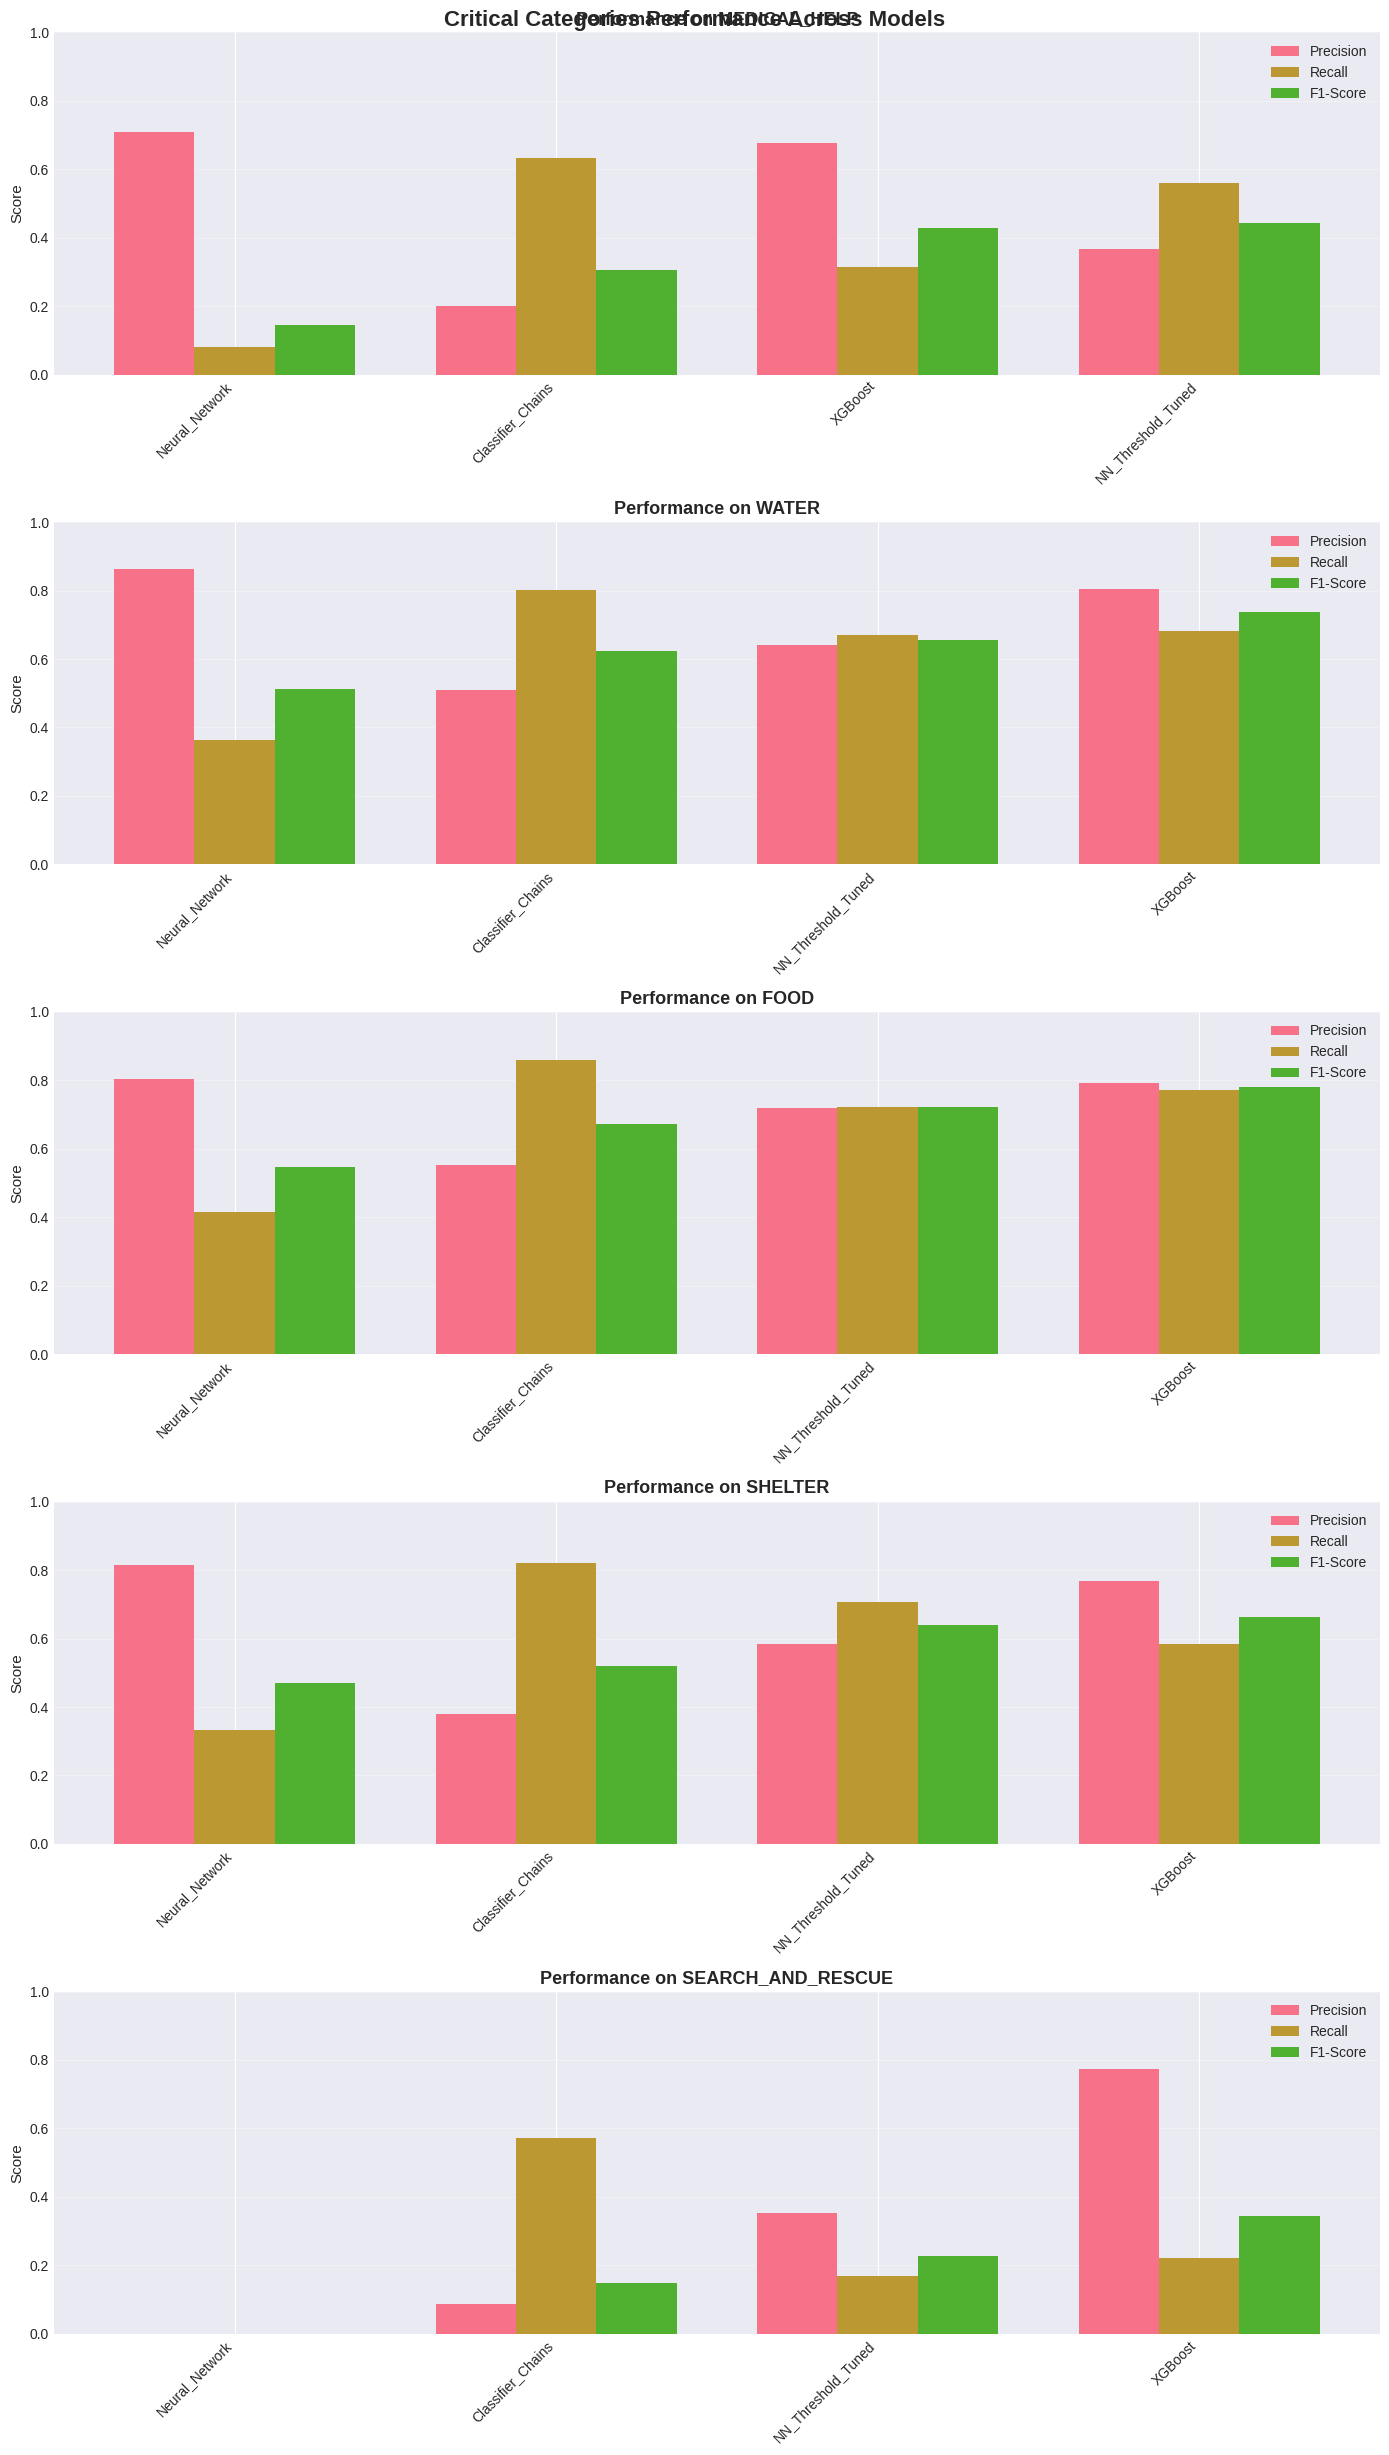

In [50]:
# Visualize critical categories performance
if critical_in_data:
    fig, axes = plt.subplots(len(critical_in_data), 1,
                            figsize=(14, 5*len(critical_in_data)))

    if len(critical_in_data) == 1:
        axes = [axes]

    for idx, category in enumerate(critical_in_data):
        cat_data = critical_df[critical_df['Category'] == category]
        cat_data = cat_data.sort_values('F1')

        x = np.arange(len(cat_data))
        width = 0.25

        axes[idx].bar(x - width, cat_data['Precision'], width, label='Precision')
        axes[idx].bar(x, cat_data['Recall'], width, label='Recall')
        axes[idx].bar(x + width, cat_data['F1'], width, label='F1-Score')

        axes[idx].set_ylabel('Score', fontsize=11)
        axes[idx].set_title(f'Performance on {category.upper()}',
                           fontsize=13, fontweight='bold')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(cat_data['Model'], rotation=45, ha='right')
        axes[idx].legend()
        axes[idx].set_ylim(0, 1)
        axes[idx].grid(axis='y', alpha=0.3)

    plt.suptitle('Critical Categories Performance Across Models',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 17. Final Model Selection & Test Set Evaluation

In [51]:
# Select best model based on F1-Micro
best_model_name = comparison_df.iloc[0]['Model']

print(f"\nBest performing model: {best_model_name}")
print(f"Validation F1-Score (Micro): {comparison_df.iloc[0]['F1 (Micro)']:.4f}")

# Ensure label_names is defined (reload if necessary)
if 'label_names' not in locals():
    print("\nReloading label_names...")
    label_names = y_train.columns.tolist()
    print(f"Loaded {len(label_names)} labels")

# Map model name to actual model object
model_mapping = {
    'Classifier_Chains': chain_model,
    'XGBoost': xgb_model,
    'Neural_Network': nn_model,
    'NN_Threshold_Tuned': nn_model  # Same model, different thresholding
}


Best performing model: XGBoost
Validation F1-Score (Micro): 0.6759


# 18. Model Optimization

Adding pre-label weighted training (to address potential class imbalance) and gridsearchcv (to tune hyperparameters)

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import time

# Filter out constant labels, same as original
one_class_labels = y_train.columns[(y_train.sum(axis=0) == 0) | (y_train.sum(axis=0) == len(y_train))]
y_train_filtered = y_train.drop(columns=one_class_labels)
print(f"Removed {len(one_class_labels)} constant labels.")

# Base Estimator
xgb_base = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    device='cpu',
    n_jobs=1,
    random_state=42,
    verbosity=0
)

# Define grid to try randomized search on to find more optimal hyperparameters
param_distributions = {
    'estimator__max_depth': [3, 5, 8],
    'estimator__learning_rate': [0.1, 0.2],
    'estimator__n_estimators': [100, 200]
}

# Randomized Search
multi_target_xgb = MultiOutputClassifier(xgb_base, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=multi_target_xgb,
    param_distributions=param_distributions,
    n_iter=5,        # Keep it small for speed
    cv=2,
    scoring='f1_micro',
    verbose=2,
    random_state=42,
    n_jobs=1
)

print("Start time for estimation of task time.")
start_time = time.time()

random_search.fit(X_train_processed, y_train_filtered)

print(f"\n Search finished in {time.time() - start_time:.2f} seconds")
best_params = random_search.best_params_
print("Best Parameters:", best_params)

final_depth = best_params['estimator__max_depth']
final_lr = best_params['estimator__learning_rate']
final_n = best_params['estimator__n_estimators']

Removed 3 constant labels.
Starting High-Speed CPU Search...
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END estimator__learning_rate=0.2, estimator__max_depth=8, estimator__n_estimators=100; total time=  51.8s
[CV] END estimator__learning_rate=0.2, estimator__max_depth=8, estimator__n_estimators=100; total time=  24.7s
[CV] END estimator__learning_rate=0.2, estimator__max_depth=5, estimator__n_estimators=200; total time=  56.8s
[CV] END estimator__learning_rate=0.2, estimator__max_depth=5, estimator__n_estimators=200; total time=  26.0s
[CV] END estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100; total time=  17.3s
[CV] END estimator__learning_rate=0.1, estimator__max_depth=3, estimator__n_estimators=100; total time=   8.1s
[CV] END estimator__learning_rate=0.2, estimator__max_depth=5, estimator__n_estimators=100; total time=  29.6s
[CV] END estimator__learning_rate=0.2, estimator__max_depth=5, estimator__n_estimators=100; total time

In [57]:
import pandas as pd
import time
from sklearn.metrics import classification_report

print(f"Training final models (CPU) with Depth={final_depth}, LR={final_lr}, N={final_n}...")
start_time = time.time()

label_models = {}
y_val_pred_optimized = pd.DataFrame(index=y_val.index, columns=y_train_filtered.columns)

# Loop through labels
for i, label in enumerate(y_train_filtered.columns):

    # Progress indicator
    if i % 5 == 0:
        print(f"  Training label {i+1}/{len(y_train_filtered.columns)}: {label}...")

    # Calculate class weight
    n_pos = y_train_filtered[label].sum()
    n_neg = len(y_train_filtered) - n_pos
    scale_weight = n_neg / n_pos if n_pos > 0 else 1.0

    # Initialize CPU Model
    clf = XGBClassifier(
        n_estimators=final_n,
        max_depth=final_depth,
        learning_rate=final_lr,
        scale_pos_weight=scale_weight,
        tree_method='hist',
        device='cpu',
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )

    # Train
    clf.fit(X_train_processed, y_train_filtered[label])
    label_models[label] = clf
    y_val_pred_optimized[label] = clf.predict(X_val_processed)

print(f"Training finished in {time.time() - start_time:.2f}s")

# Evaluate
print("\nOptimized CPU Performance:")
print(classification_report(y_val_filtered, y_val_pred_optimized,
                            target_names=y_train_filtered.columns,
                            zero_division=0))

Training final models (CPU) with Depth=5, LR=0.2, N=200...
  Training label 1/34: related...
  Training label 6/34: search_and_rescue...
  Training label 11/34: shelter...
  Training label 16/34: death...
  Training label 21/34: electricity...
  Training label 26/34: other_infrastructure...
  Training label 31/34: earthquake...
Training finished in 252.90s

Optimized CPU Performance:
                        precision    recall  f1-score   support

               related       0.93      0.75      0.83      1940
               request       0.60      0.76      0.67       421
           aid_related       0.73      0.72      0.72      1048
          medical_help       0.42      0.60      0.49       213
      medical_products       0.31      0.56      0.40       136
     search_and_rescue       0.18      0.36      0.24        77
              security       0.11      0.24      0.15        54
              military       0.45      0.70      0.55        97
                 water       0.60   

In [58]:
import joblib
import os
import json

# Define the save path in Drive
save_dir = '/content/drive/MyDrive/AAI_Capstone/Models'
os.makedirs(save_dir, exist_ok=True)

# Save the entire dictionary of trained models
model_path = os.path.join(save_dir, 'optimized_xgboost_multilabel.pkl')
print(f"Saving models to {model_path}...")
joblib.dump(label_models, model_path)

# Save the best hyperparameters for reference
params_path = os.path.join(save_dir, 'best_hyperparameters.json')
with open(params_path, 'w') as f:
    params_to_save = {
        'max_depth': final_depth,
        'learning_rate': final_lr,
        'n_estimators': final_n
    }
    json.dump(params_to_save, f, indent=4)

print("Models and parameters saved.")

Saving models to /content/drive/MyDrive/AAI_Capstone/Models/optimized_xgboost_multilabel.pkl...
Models and parameters saved.


In [59]:
import joblib
import os
import pandas as pd

load_path = '/content/drive/MyDrive/AAI_Capstone/Models/optimized_xgboost_multilabel.pkl'

print("Loading models...")
loaded_label_models = joblib.load(load_path)

print(f"Loaded {len(loaded_label_models)} trained models.")

# Generate predictions on validation data
# Ensure X_val_processed is generated first
y_val_pred_loaded = pd.DataFrame(index=y_val.index, columns=y_train.columns)

for label, clf in loaded_label_models.items():
    # Only loop through labels present in the saved dictionary
    y_val_pred_loaded[label] = clf.predict(X_val_processed)

print("Predictions generated.")

Loading models...
Loaded 34 trained models.
Predictions generated.
